# 0. Khai báo schema

In [1]:
from pyspark.sql.types import StructType, StructField, IntegerType, DoubleType, StringType


borrower_profile_schema = StructType([
    StructField("id", IntegerType(), True),
    StructField("member_id", IntegerType(), True),
    StructField("emp_title", StringType(), True),
    StructField("emp_length", StringType(), True),
    StructField("home_ownership", StringType(), True),
    StructField("annual_inc", DoubleType(), True),
    StructField("verification_status", StringType(), True),
    StructField("addr_state", StringType(), True),
    StructField("zip_code", StringType(), True)
])

loan_info_schema = StructType([
    StructField("id", IntegerType(), True),
    StructField("member_id", IntegerType(), True),
    StructField("loan_amnt", DoubleType(), True),
    StructField("funded_amnt", DoubleType(), True),
    StructField("funded_amnt_inv", DoubleType(), True),
    StructField("term", StringType(), True),
    StructField("int_rate", DoubleType(), True),
    StructField("installment", DoubleType(), True),
    StructField("grade", StringType(), True),
    StructField("sub_grade", StringType(), True),
    StructField("purpose", StringType(), True),
    StructField("title", StringType(), True),
    StructField("issue_d", StringType(), True),
    StructField("policy_code", DoubleType(), True),
    StructField("application_type", StringType(), True)
])

loan_status_history_schema = StructType([
    StructField("id", IntegerType(), True),
    StructField("loan_status", StringType(), True),
    StructField("pymnt_plan", StringType(), True),
    StructField("initial_list_status", StringType(), True),
    StructField("last_pymnt_d", StringType(), True),
    StructField("next_pymnt_d", StringType(), True),
    StructField("last_pymnt_amnt", DoubleType(), True),
    StructField("out_prncp", DoubleType(), True),
    StructField("out_prncp_inv", DoubleType(), True)
])

repayment_summary_schema = StructType([
    StructField("id", IntegerType(), True),
    StructField("total_pymnt", DoubleType(), True),
    StructField("total_pymnt_inv", DoubleType(), True),
    StructField("total_rec_prncp", DoubleType(), True),
    StructField("total_rec_int", DoubleType(), True),
    StructField("total_rec_late_fee", DoubleType(), True),
    StructField("recoveries", DoubleType(), True),
    StructField("collection_recovery_fee", DoubleType(), True)
])

credit_profile_schema = StructType([
    StructField("id", IntegerType(), True),
    StructField("member_id", IntegerType(), True),
    StructField("delinq_2yrs", DoubleType(), True),
    StructField("earliest_cr_line", StringType(), True),
    StructField("inq_last_6mths", DoubleType(), True),
    StructField("mths_since_last_delinq", DoubleType(), True),
    StructField("mths_since_last_record", DoubleType(), True),
    StructField("open_acc", DoubleType(), True),
    StructField("pub_rec", DoubleType(), True),
    StructField("revol_bal", DoubleType(), True),
    StructField("revol_util", DoubleType(), True),
    StructField("total_acc", DoubleType(), True),
    StructField("collections_12_mths_ex_med", DoubleType(), True),
    StructField("mths_since_last_major_derog", DoubleType(), True)
])

credit_account_detail_schema = StructType([
    StructField("id", IntegerType(), True),
    StructField("member_id", IntegerType(), True),
    StructField("open_acc_6m", DoubleType(), True),
    StructField("open_il_6m", DoubleType(), True),
    StructField("open_il_12m", DoubleType(), True),
    StructField("open_il_24m", DoubleType(), True),
    StructField("mths_since_rcnt_il", DoubleType(), True),
    StructField("total_bal_il", DoubleType(), True),
    StructField("il_util", DoubleType(), True),
    StructField("open_rv_12m", DoubleType(), True),
    StructField("open_rv_24m", DoubleType(), True),
    StructField("max_bal_bc", DoubleType(), True),
    StructField("all_util", DoubleType(), True),
    StructField("total_rev_hi_lim", DoubleType(), True),
    StructField("tot_coll_amt", DoubleType(), True),
    StructField("tot_cur_bal", DoubleType(), True),
    StructField("inq_fi", DoubleType(), True),
    StructField("total_cu_tl", DoubleType(), True),
    StructField("inq_last_12m", DoubleType(), True)
])

joint_application_schema = StructType([
    StructField("id", IntegerType(), True),
    StructField("annual_inc_joint", DoubleType(), True),
    StructField("dti_joint", DoubleType(), True),
    StructField("verification_status_joint", StringType(), True),
    StructField("acc_now_delinq", DoubleType(), True)
])

meta_reference_schema = StructType([
    StructField("id", IntegerType(), True),
    StructField("url", StringType(), True),
    StructField("desc", StringType(), True)
])

# 1. Borrower_profile: Hồ sơ người vay

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, mean, when, round as spark_round, isnan, desc, avg
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [26]:
spark = SparkSession.builder \
    .master("spark://spark-master:7077") \
    .appName("EDA_BorrowerProfile") \
    .getOrCreate()

In [33]:
borrower_profile_df = (
    spark.read
    .option("header", True)
    .option("quote", '"')
    .option("delimiter", ",")
    .option("encoding", "UTF-8")
    .schema(borrower_profile_schema)
    .csv("hdfs://namenode:9000/bigdata/data/splitted_data/borrower_profile")
)
borrower_profile_df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- member_id: integer (nullable = true)
 |-- emp_title: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: double (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- zip_code: string (nullable = true)



## Thống kê mô tả cơ bản cho thu nhập hàng năm

In [34]:
numeric_stats = borrower_profile_df.select("annual_inc").describe()
numeric_stats.show()

+-------+-----------------+
|summary|       annual_inc|
+-------+-----------------+
|  count|           886309|
|   mean|75019.59328920276|
| stddev|64691.82406591965|
|    min|              0.0|
|    max|        9500000.0|
+-------+-----------------+



## Một số thống kê quan trọng

In [35]:
def freq_table(col_name, top_n=15):
    print(f"\n=== Frequency: {col_name} ===")
    borrower_profile_df.groupBy(col_name).count().orderBy(desc("count")).show(top_n, truncate=False)

for col_name in ["emp_title", "emp_length", "home_ownership", "verification_status", "addr_state", "zip_code"]:
    if col_name in borrower_profile_df.columns:
        freq_table(col_name)


=== Frequency: emp_title ===
+----------------+-----+
|emp_title       |count|
+----------------+-----+
|Unknown         |51374|
|Teacher         |13795|
|Manager         |11631|
|Registered Nurse|5689 |
|Owner           |5508 |
|RN              |5485 |
|Supervisor      |5411 |
|Sales           |4454 |
|Project Manager |4085 |
|Driver          |3720 |
|Office Manager  |3614 |
|Director        |3326 |
|General Manager |3280 |
|manager         |3246 |
|teacher         |2976 |
+----------------+-----+
only showing top 15 rows


=== Frequency: emp_length ===
+----------+------+
|emp_length|count |
+----------+------+
|10+ years |291305|
|2 years   |78763 |
|< 1 year  |70435 |
|3 years   |69938 |
|1 year    |56987 |
|5 years   |55646 |
|4 years   |52461 |
|n/a       |44795 |
|7 years   |44547 |
|8 years   |43916 |
|6 years   |42906 |
|9 years   |34610 |
+----------+------+


=== Frequency: home_ownership ===
+--------------+------+
|home_ownership|count |
+--------------+------+
|MORTGAGE 

## Tỷ lệ các giá trị unique ở 3 cột emp_length, home_ownership, verification_status

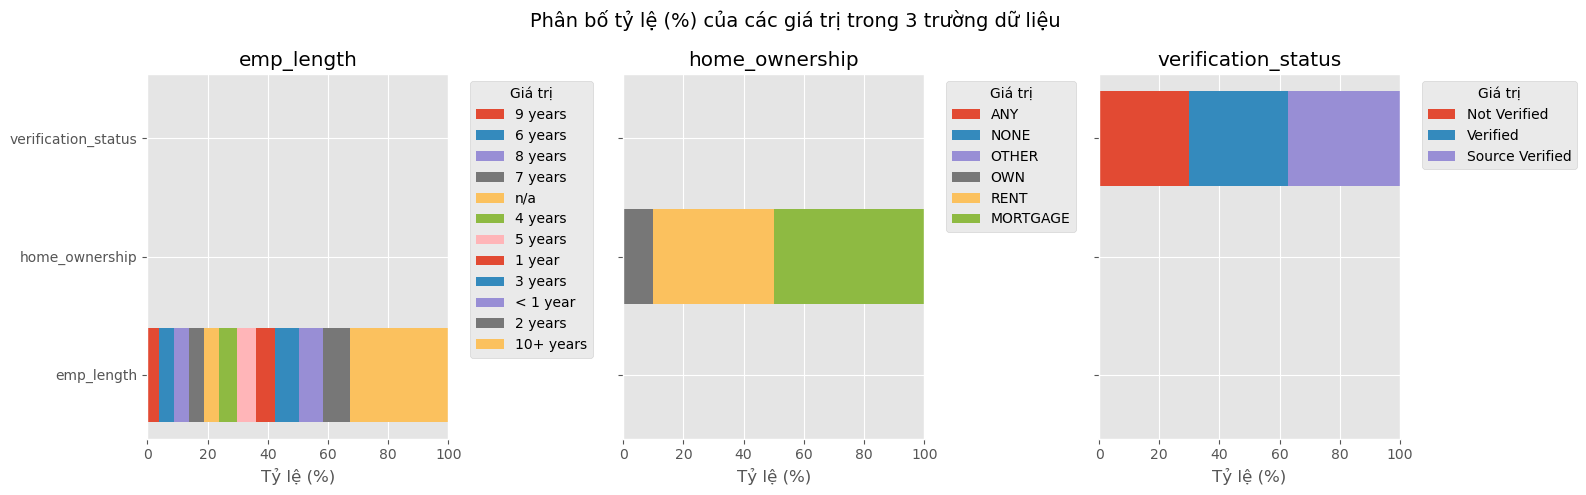

In [36]:
cols = ["emp_length", "home_ownership", "verification_status"]

total_rows = borrower_profile_df.count()

combined = pd.DataFrame()
for c in cols:
    temp = (
        borrower_profile_df.groupBy(c)
          .agg(count("*").alias("count"))
          .withColumn("pct", (col("count") / total_rows) * 100)
          .orderBy(col("pct").desc())
          .toPandas()
    )
    temp["column"] = c
    temp = temp.rename(columns={c: "value"})
    combined = pd.concat([combined, temp[["column", "value", "pct"]]], ignore_index=True)

fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharey=True)

for i, c in enumerate(cols):
    borrower_profile_df_sub = combined[combined["column"] == c].copy()
    borrower_profile_df_sub = borrower_profile_df_sub.sort_values("pct", ascending=True)  # để thứ tự đẹp hơn

    left = 0
    for _, row in borrower_profile_df_sub.iterrows():
        axes[i].barh([c], row["pct"], left=left, label=row["value"])
        left += row["pct"]

    # Trang trí từng subplot
    axes[i].set_title(f"{c}")
    axes[i].set_xlim(0, 100)
    axes[i].set_xlabel("Tỷ lệ (%)")
    axes[i].set_ylabel("")
    axes[i].legend(title="Giá trị", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.suptitle("Phân bố tỷ lệ (%) của các giá trị trong 3 trường dữ liệu", fontsize=14)
plt.tight_layout()
plt.show()

## Trung bình thu nhập theo các nhóm

In [37]:
if "home_ownership" in borrower_profile_df.columns and "annual_inc" in borrower_profile_df.columns:
    avg_by_home = borrower_profile_df.groupBy("home_ownership").agg(spark_round(mean("annual_inc"), 2).alias("avg_income"))
    print("\n=== Average income by home_ownership ===")
    avg_by_home.show()

if "verification_status" in borrower_profile_df.columns and "annual_inc" in borrower_profile_df.columns:
    avg_by_verif = borrower_profile_df.groupBy("verification_status").agg(spark_round(mean("annual_inc"), 2).alias("avg_income"))
    print("\n=== Average income by verification_status ===")
    avg_by_verif.show()


=== Average income by home_ownership ===
+--------------+----------+
|home_ownership|avg_income|
+--------------+----------+
|           OWN|  68896.52|
|          RENT|  63976.73|
|      MORTGAGE|  85095.81|
|           ANY|  63726.67|
|          NONE|  61632.98|
|         OTHER|  66892.75|
+--------------+----------+


=== Average income by verification_status ===
+-------------------+----------+
|verification_status|avg_income|
+-------------------+----------+
|           Verified|  78181.66|
|    Source Verified|  78904.47|
|       Not Verified|   66760.9|
+-------------------+----------+



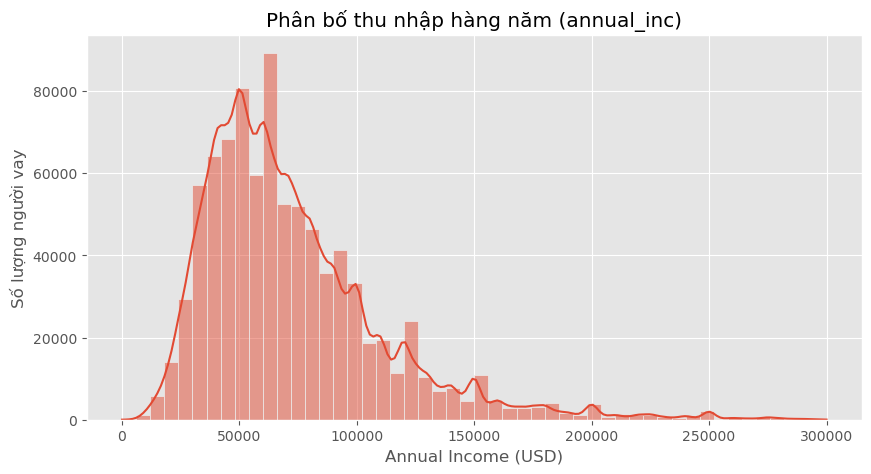

In [38]:
plt.style.use("ggplot")
income_pd = borrower_profile_df.select("annual_inc").dropna().toPandas()
income_pd = income_pd[income_pd["annual_inc"] < 300000] 

plt.figure(figsize=(10,5))
sns.histplot(income_pd["annual_inc"], bins=50, kde=True)
plt.title("Phân bố thu nhập hàng năm (annual_inc)")
plt.xlabel("Annual Income (USD)")
plt.ylabel("Số lượng người vay")
plt.show()

## Phân bố loại sở hữu nhà (Home Ownership)

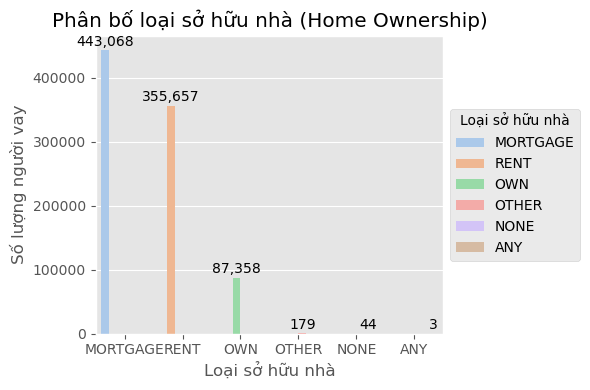

In [39]:
home_borrower_profile_df = borrower_profile_df.groupBy("home_ownership").count().orderBy("count", ascending=False)
home_pd = home_borrower_profile_df.toPandas()

plt.figure(figsize=(6,4))
ax = sns.barplot(
    x="home_ownership", 
    y="count", 
    hue="home_ownership",
    data=home_pd, 
    palette="pastel", 
)

for p in ax.patches:
    height = p.get_height()
    if not np.isnan(height):
        ax.text(
            p.get_x() + p.get_width() / 2,
            height + home_pd["count"].max() * 0.005,
            f"{int(height):,}",
            ha="center", va="bottom", fontsize=10
        )
ax.legend(
    title="Loại sở hữu nhà",
    loc="center left",
    bbox_to_anchor=(1, 0.5)
)
plt.title("Phân bố loại sở hữu nhà (Home Ownership)")
plt.xlabel("Loại sở hữu nhà")
plt.ylabel("Số lượng người vay")
plt.tight_layout()
plt.show()



## Phân bố tình trạng xác minh thu nhập (Verification Status)

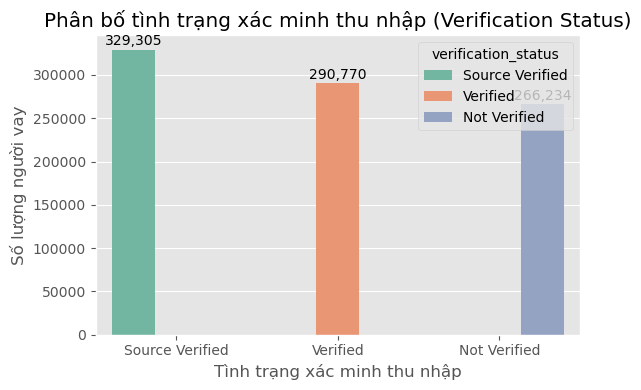

In [40]:
verif_pd = borrower_profile_df.groupBy("verification_status").count().orderBy(desc("count")).toPandas()

plt.figure(figsize=(6,4))
ax = sns.barplot(
    x="verification_status",
    y="count",
    hue="verification_status",
    data=verif_pd,
    palette="Set2",
)

for p in ax.patches:
    height = p.get_height()
    if not np.isnan(height):
        ax.text(
            p.get_x() + p.get_width() / 2,
            height + verif_pd["count"].max() * 0.005,
            f"{int(height):,}",
            ha="center", va="bottom", fontsize=10
        )
        
plt.title("Phân bố tình trạng xác minh thu nhập (Verification Status)")
plt.xlabel("Tình trạng xác minh thu nhập")
plt.ylabel("Số lượng người vay")
plt.tight_layout()
plt.show()



## Phân bố thời gian làm việc của người vay (Emp Length)

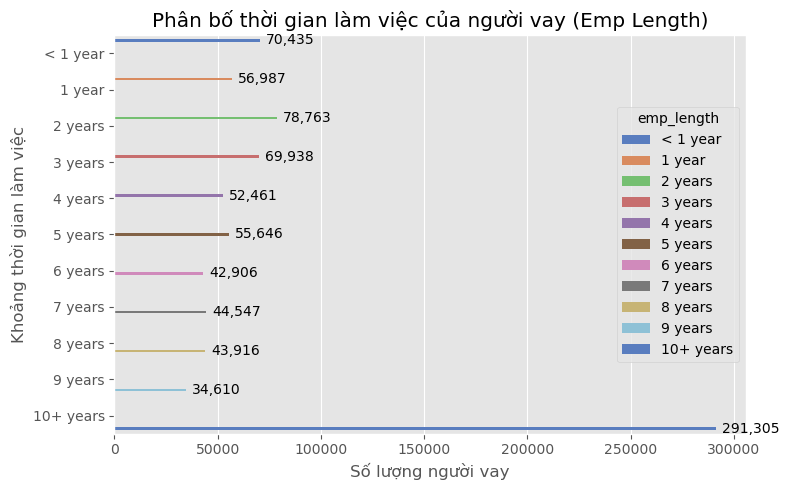

In [41]:
emp_pd = borrower_profile_df.groupBy("emp_length").count().toPandas()

order = [
    "< 1 year", "1 year", "2 years", "3 years", "4 years",
    "5 years", "6 years", "7 years", "8 years", "9 years", "10+ years"
]

emp_pd = emp_pd[emp_pd["emp_length"].isin(order)]
emp_pd["emp_length"] = pd.Categorical(emp_pd["emp_length"], categories=order, ordered=True)
emp_pd = emp_pd.sort_values("emp_length")

plt.figure(figsize=(8,5))
ax = sns.barplot(
    y="emp_length",
    x="count",
    hue="emp_length",
    data=emp_pd,
    palette="muted",
)

for p in ax.patches:
    width = p.get_width()
    if not np.isnan(width):
        ax.text(
            width + emp_pd["count"].max() * 0.01, 
            p.get_y() + p.get_height() / 2,
            f"{int(width):,}",                   
            va="center", ha="left", fontsize=10
        )

plt.title("Phân bố thời gian làm việc của người vay (Emp Length)")
plt.xlabel("Số lượng người vay")
plt.ylabel("Khoảng thời gian làm việc")
plt.tight_layout()
plt.show()



## Top 10 bang/khu vực có nhiều người vay nhất

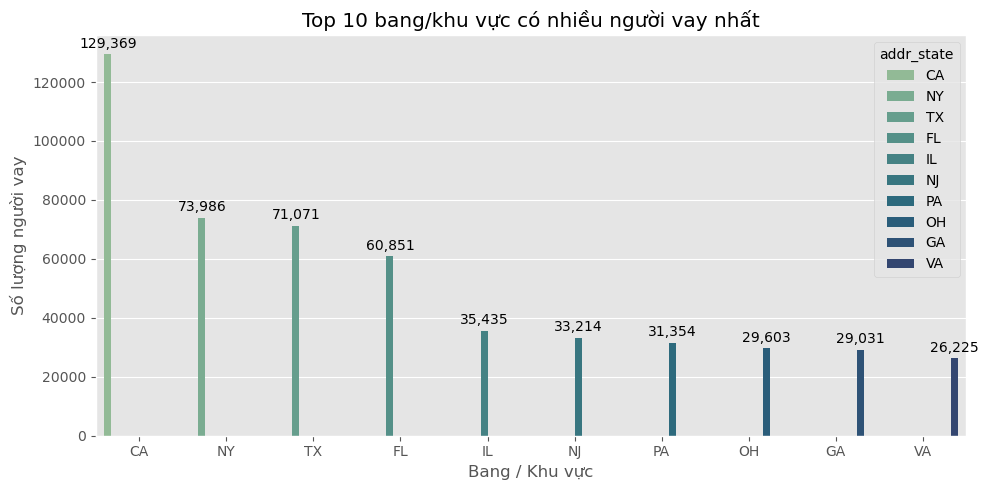

In [42]:
state_pd = (
    borrower_profile_df.groupBy("addr_state")
      .count()
      .orderBy(desc("count"))
      .limit(10)
      .toPandas()
)

plt.figure(figsize=(10, 5))
ax = sns.barplot(
    x="addr_state",
    y="count",
    data=state_pd,
    hue="addr_state",
    palette="crest",
)

for p in ax.patches:
    height = p.get_height()
    if not np.isnan(height):  # bỏ qua nếu giá trị là NaN
        ax.text(
            p.get_x() + p.get_width() / 2,
            height + state_pd["count"].max() * 0.01,
            f"{int(height):,}",
            ha="center", va="bottom", fontsize=10
        )

plt.title("Top 10 bang/khu vực có nhiều người vay nhất")
plt.xlabel("Bang / Khu vực")
plt.ylabel("Số lượng người vay")
plt.tight_layout()
plt.show()



In [43]:
spark.stop()

# 2. Loan_info: Thông tin khoản vay

In [48]:
spark = SparkSession.builder \
    .master("spark://spark-master:7077") \
    .appName("EDA_LoanInfo") \
    .getOrCreate()

In [49]:
loan_df = (
    spark.read
    .option("header", True)
    .option("quote", '"')
    .option("delimiter", ",")
    .option("encoding", "UTF-8")
    .schema(loan_info_schema)
    .csv("hdfs://namenode:9000/bigdata/data/splitted_data/loan_info")
)
p_loan_df = loan_df.toPandas()
loan_df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- member_id: integer (nullable = true)
 |-- loan_amnt: double (nullable = true)
 |-- funded_amnt: double (nullable = true)
 |-- funded_amnt_inv: double (nullable = true)
 |-- term: string (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- installment: double (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- title: string (nullable = true)
 |-- issue_d: string (nullable = true)
 |-- policy_code: double (nullable = true)
 |-- application_type: string (nullable = true)



## Thống kê mô tả tổng quát

In [50]:
loan_df.describe(["loan_amnt", "funded_amnt", "funded_amnt_inv", "int_rate", "installment"]).show()

+-------+------------------+------------------+------------------+------------------+-----------------+
|summary|         loan_amnt|       funded_amnt|   funded_amnt_inv|          int_rate|      installment|
+-------+------------------+------------------+------------------+------------------+-----------------+
|  count|            886309|            886309|            886309|            886309|           886309|
|   mean|14758.921860209024|14745.669935654496|14707.464974100456|13.246282222113768|436.8088670881018|
| stddev| 8434.560405312674| 8429.020420875398| 8440.122486131671| 4.382057313669209|244.1522564673065|
|    min|             500.0|             500.0|               0.0|              5.32|            15.67|
|    max|           35000.0|           35000.0|           35000.0|             28.99|          1445.46|
+-------+------------------+------------------+------------------+------------------+-----------------+



In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

def hist_with_numbers(series, title, xlabel):
    plt.figure(figsize=(20,6))
    ax = sns.histplot(series, bins=50, kde=True)

    for p in ax.patches:
        height = int(p.get_height())
        if height > 0:
            ax.annotate(
                str(height),
                (p.get_x() + p.get_width()/2, height),
                ha='center', va='bottom', fontsize=8
            )

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Số lượng (count)")
    plt.tight_layout()
    plt.show()


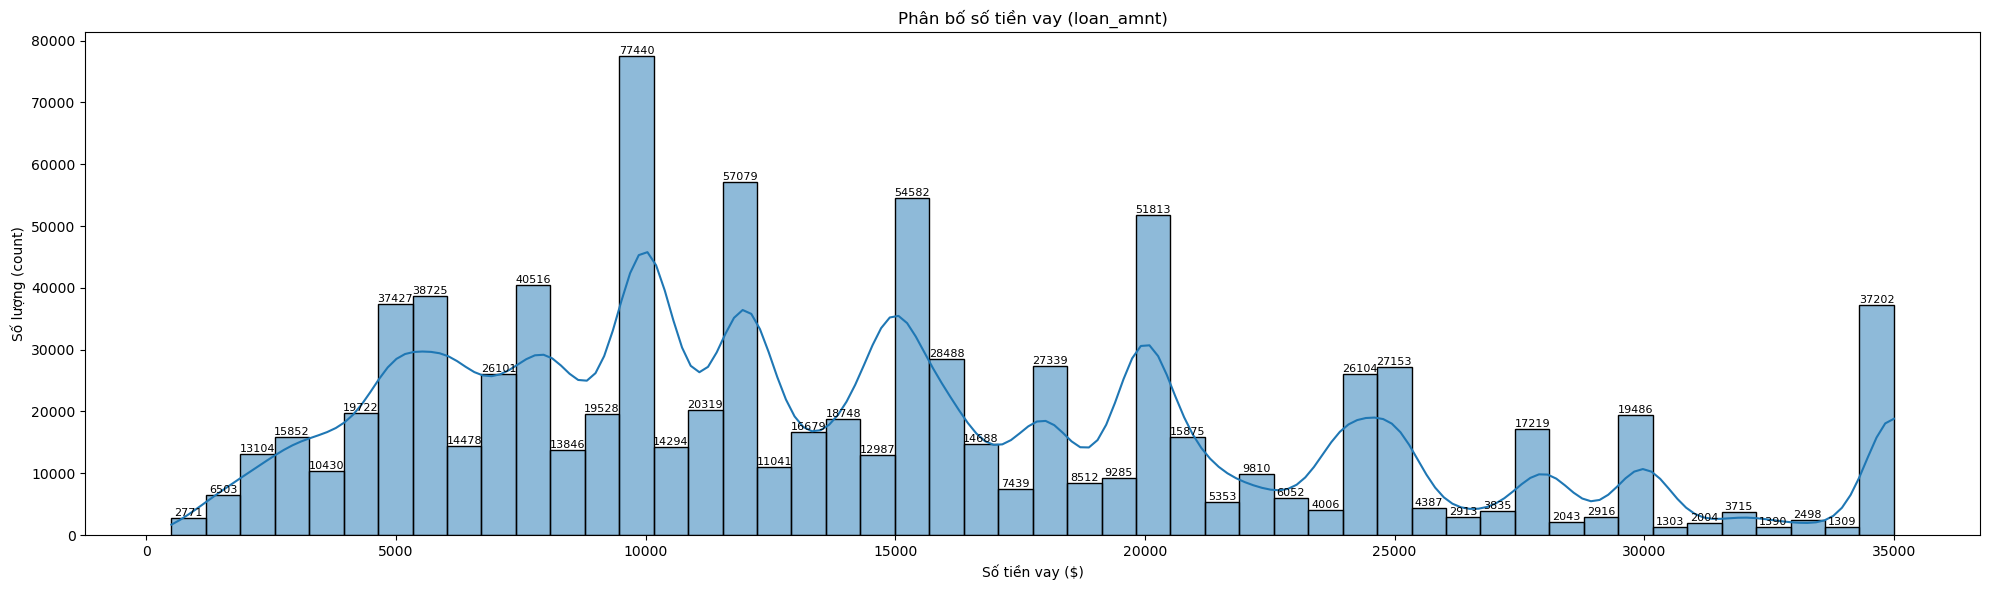

In [52]:
hist_with_numbers(
    p_loan_df["loan_amnt"],
    "Phân bố số tiền vay (loan_amnt)",
    "Số tiền vay ($)"
)


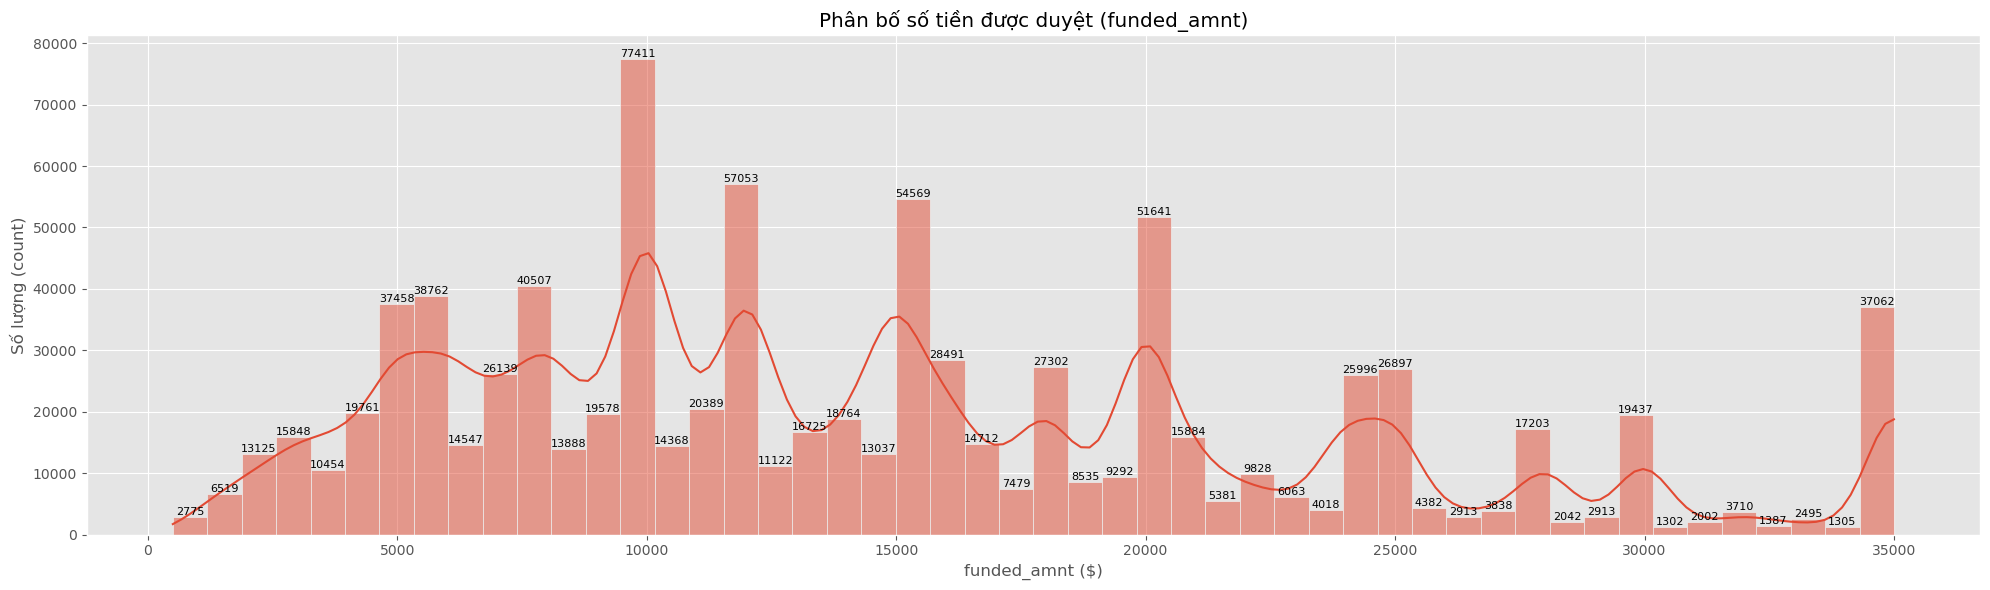

In [49]:
hist_with_numbers(
    p_loan_df["funded_amnt"],
    "Phân bố số tiền được duyệt (funded_amnt)",
    "funded_amnt ($)"
)


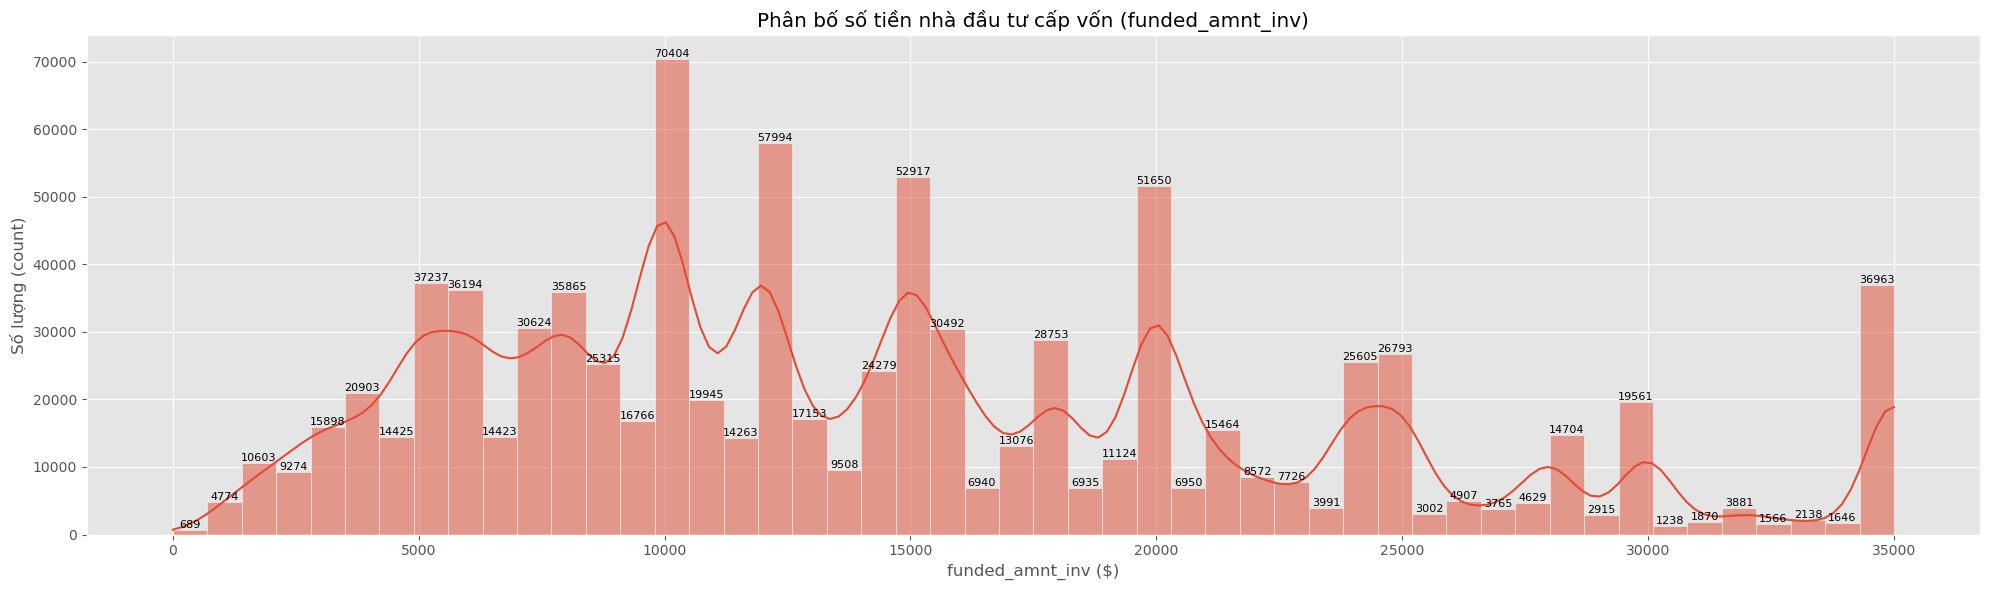

In [50]:
hist_with_numbers(
    p_loan_df["funded_amnt_inv"],
    "Phân bố số tiền nhà đầu tư cấp vốn (funded_amnt_inv)",
    "funded_amnt_inv ($)"
)



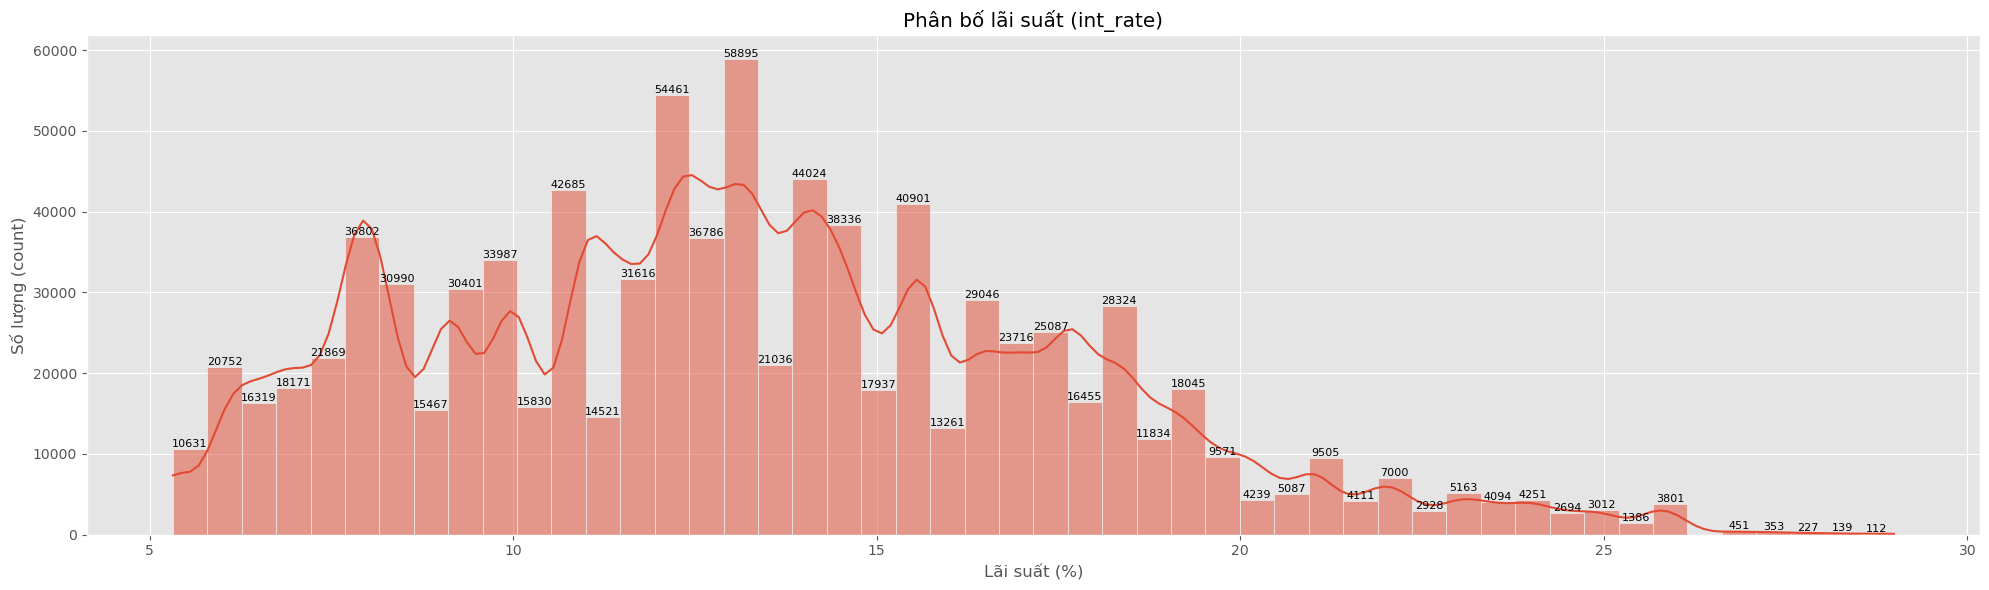

In [51]:
hist_with_numbers(
    p_loan_df["int_rate"],
    "Phân bố lãi suất (int_rate)",
    "Lãi suất (%)"
)



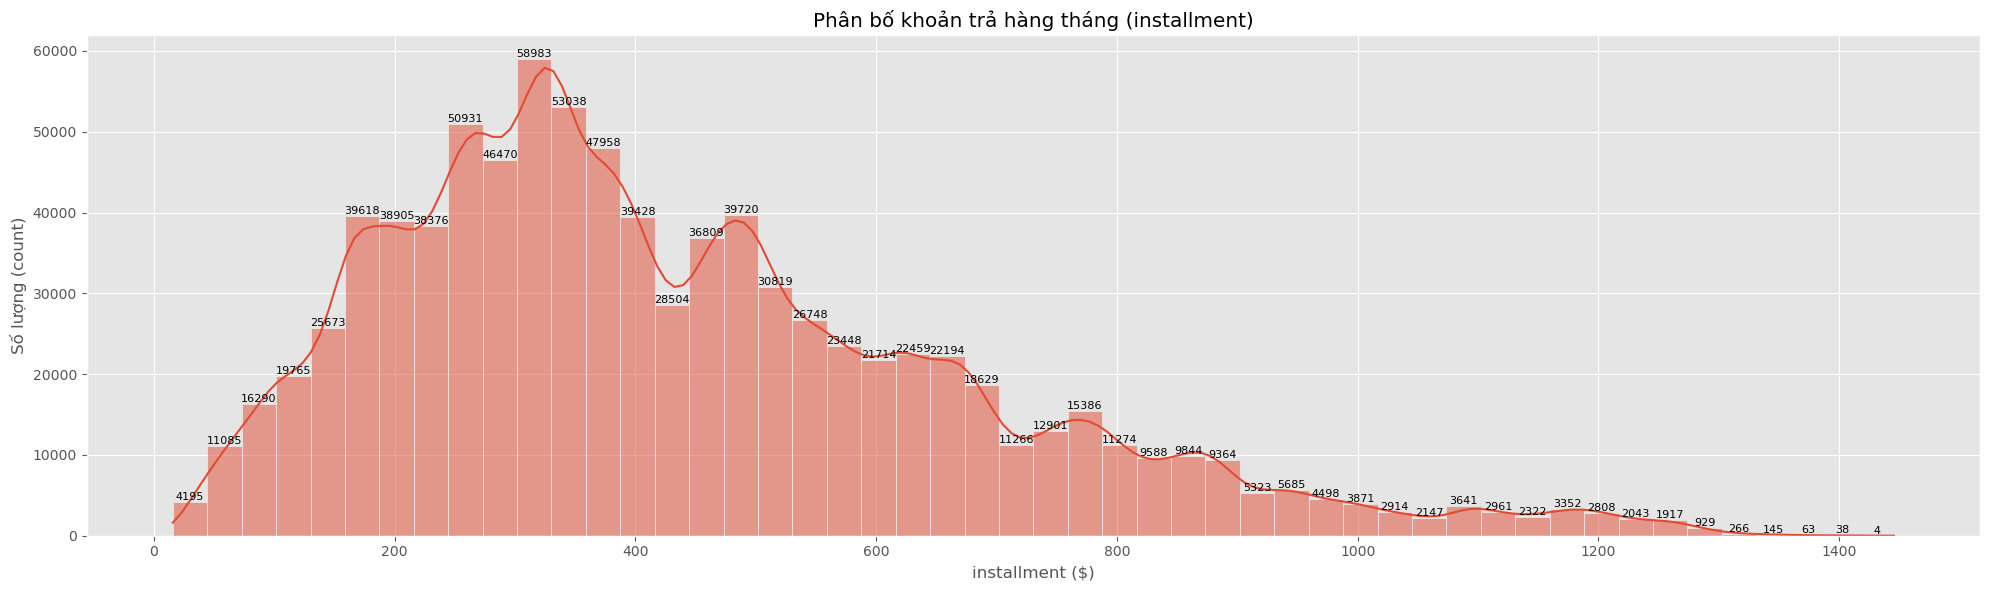

In [52]:
hist_with_numbers(
    p_loan_df["installment"],
    "Phân bố khoản trả hàng tháng (installment)",
    "installment ($)"
)


In [ ]:
loan_df = loan_df.withColumn("funded_ratio", col("funded_amnt") / col("loan_amnt"))
loan_df.select(avg("funded_ratio")).show()
p_loan_df = loan_df.toPandas()

plt.figure(figsize=(7,5))
sns.histplot(p_loan_df["funded_ratio"], bins=100, kde=True, color="skyblue")
plt.xlim(0.95, 1.01)
plt.title("Phân phối tỷ lệ tài trợ")
plt.xlabel("Tỷ lệ tài trợ")
plt.ylabel("Số khoản vay")
plt.show()


+------------------+
| avg(funded_ratio)|
+------------------+
|0.9992938377209872|
+------------------+



## Thống kê theo thời hạn vay (term)

In [ ]:
loan_df.groupBy("term").count().orderBy("count", ascending=False).show()
term_pd = loan_df.groupBy("term").count().toPandas()
total = term_pd["count"].sum()
term_pd["pct"] = term_pd["count"] / total
plt.figure(figsize=(4,6))

plt.bar(
    x=["term"], 
    height=term_pd.loc[term_pd["term"]=="36 months", "pct"], 
    label="36 months"
)
plt.bar(
    x=["term"], 
    height=term_pd.loc[term_pd["term"]=="60 months", "pct"], 
    bottom=term_pd.loc[term_pd["term"]=="36 months", "pct"], 
    label="60 months"
)

bottom = 0
for i, row in term_pd.iterrows():
    plt.text(
        0, 
        bottom + row["pct"]/2, 
        f"{row['pct']*100:.2f}%", 
        ha="center", 
        va="center", 
        color="white", 
        fontweight="bold"
    )
    bottom += row["pct"]

plt.ylabel("Tỷ lệ (%)")
plt.title("Phân bố thời hạn khoản vay (term)")
plt.legend(title="Term")
plt.ylim(0,1)
plt.show()

## Thống kê theo hạng tín dụng (grade)

In [ ]:
loan_df.groupBy("grade").count().orderBy("grade").show()
grade_pd = loan_df.groupBy("grade").count().orderBy("grade").toPandas()

# Tính phần trăm
total = grade_pd["count"].sum()
grade_pd["pct"] = grade_pd["count"] / total

# Vẽ stacked bar
plt.figure(figsize=(6,6))
bottom = 0
colors = plt.cm.tab20.colors 

for i, row in grade_pd.iterrows():
    plt.bar(
        x=["grade"], 
        height=row["pct"], 
        bottom=bottom, 
        label=row["grade"], 
        color=colors[i % len(colors)]
    )
    # Ghi % ở giữa từng phần
    plt.text(
        0, 
        bottom + row["pct"]/2, 
        f"{row['pct']*100:.2f}%", 
        ha="center", va="center", color="white", fontweight="bold"
    )
    bottom += row["pct"]

plt.title("Phân bố hạng tín dụng (grade) theo tỷ lệ %")
plt.ylim(0,1)
plt.ylabel("Tỷ lệ (%)")
plt.legend(title="Grade", bbox_to_anchor=(1.05, 1))
plt.show()

## Phân bố mục đích vay

In [ ]:
loan_purpose = loan_df.groupBy("purpose").agg(
    count("*").alias("count"),
    avg("loan_amnt").alias("avg_loan"),
    avg("int_rate").alias("avg_interest")
).orderBy(col("count").desc())
loan_purpose.show(truncate=False)

In [ ]:
top10_purpose = p_loan_df["purpose"].value_counts().head(10).reset_index()
top10_purpose.columns = ["purpose", "count"]

plt.figure(figsize=(10, 6))
sns.barplot(
    y="purpose",
    x="count",
    hue="purpose",
    data=top10_purpose,
    palette="mako",
    dodge=False 
)
plt.legend([],[], frameon=False)

# Thêm số phía sau bar
for index, row in top10_purpose.iterrows():
    plt.text(
        row["count"] + 5000,
        index,
        str(row["count"]),
        va='center'
    )

plt.title("Top 10 mục đích vay phổ biến nhất")
plt.xlabel("Số lượng khoản vay")
plt.ylabel("Mục đích vay")
plt.tight_layout()
plt.show()

## Lãi suất trung bình theo hạng tín dụng

In [ ]:
avg_rate_by_grade = loan_df.groupBy("grade").agg(avg("int_rate").alias("avg_interest")).orderBy("grade")
avg_rate_by_grade.show()

In [ ]:
plt.figure(figsize=(8, 6))

mean_int_rate = p_loan_df.groupby("grade")["int_rate"].mean().reset_index()

sns.barplot(
    x="grade",
    y="int_rate",
    hue="grade",
    data=mean_int_rate,
    palette="Set2",
    dodge=False
)
plt.legend([],[], frameon=False)  

for index, row in mean_int_rate.iterrows():
    plt.text(
        index,       
        row["int_rate"] + 0.1, 
        f"{row['int_rate']:.2f}",
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.title("Lãi suất trung bình theo hạng tín dụng (grade)")
plt.xlabel("Hạng tín dụng")
plt.ylabel("Lãi suất trung bình (%)")
plt.tight_layout()
plt.show()


## Lãi suất trung bình theo thời hạn vay

In [ ]:
avg_rate_by_term = loan_df.groupBy("term").agg(avg("int_rate").alias("avg_interest")).orderBy("term")
avg_rate_by_term.show()
avg_rate_by_term = avg_rate_by_term.toPandas()

plt.figure(figsize=(6,4))
sns.barplot(
    x="term", 
    y="avg_interest", 
    hue="term",
    data=avg_rate_by_term, 
    palette="pastel",
)

plt.title("Lãi suất trung bình theo kỳ hạn vay")
plt.xlabel("Kỳ hạn vay")
plt.ylabel("Lãi suất trung bình (%)")

# Thêm giá trị trên mỗi cột
for index, row in avg_rate_by_term.iterrows():
    plt.text(index, row.avg_interest + 0.2, f"{row.avg_interest:.2f}%", ha='center')

plt.tight_layout()
plt.show()



## Tỷ lệ tài trợ thực tế (funded_amnt / loan_amnt)

In [ ]:
loan_df = loan_df.withColumn("funded_ratio", col("funded_amnt") / col("loan_amnt"))
p_loan_df = loan_df.toPandas()

p_loan_df["funded_ratio_bin"] = pd.cut(p_loan_df["funded_ratio"], bins=20)

df_plot = p_loan_df["funded_ratio_bin"].value_counts().sort_index()

plt.figure(figsize=(12,5))
bars = plt.bar(df_plot.index.astype(str), df_plot.values)

plt.xticks(rotation=45, ha='right')
plt.title("Phân phối funded_ratio")
plt.xlabel("funded_ratio (bin)")
plt.ylabel("Số khoản vay")

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x()+bar.get_width()/2, height,
             str(height), ha='center', va='bottom', fontsize=8)

plt.show()


## Tỷ lệ số tiền phải trả mỗi kỳ so với khoản vay (installment / loan_amnt)

In [ ]:
loan_df = loan_df.withColumn(
    "installment_to_loan_ratio",
    col("installment") / col("loan_amnt")
)
p_loan_df = loan_df.toPandas()

p_loan_df["install_ratio_bin"] = pd.cut(
    p_loan_df["installment_to_loan_ratio"], bins=20
)

df_plot = p_loan_df["install_ratio_bin"].value_counts().sort_index()

plt.figure(figsize=(12,5))
bars = plt.bar(df_plot.index.astype(str), df_plot.values)

plt.xticks(rotation=45)
plt.title("Phân phối installment_to_loan_ratio")
plt.xlabel("installment_to_loan_ratio (bin)")
plt.ylabel("Số khoản vay")

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x()+bar.get_width()/2, height,
             str(height), ha='center', va='bottom', fontsize=8)

plt.show()

## Số tiền lãi phải trả mỗi kỳ (installment−loan_amnt/term)

In [ ]:
loan_df = loan_df.withColumn(
    "interest_amount",
    col("loan_amnt") * (col("int_rate") / 100)
)

p_loan_df = loan_df.toPandas()

p_loan_df["interest_amount_bin"] = pd.cut(p_loan_df["interest_amount"], bins=20)

df_plot = p_loan_df["interest_amount_bin"].value_counts().sort_index()

plt.figure(figsize=(12,5))
bars = plt.bar(df_plot.index.astype(str), df_plot.values)

plt.xticks(rotation=45)
plt.title("Phân phối interest_amount")
plt.xlabel("interest_amount (bin)")
plt.ylabel("Số khoản vay")

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x()+bar.get_width()/2, height,
             str(height), ha='center', va='bottom', fontsize=8)

plt.show()


## Tỷ lệ mức được giải ngân (funded_amnt / loan_amnt)

In [ ]:
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df1 = loan_df.withColumn(
    "funded_ratio",
    col("funded_amnt") / col("loan_amnt")
)

pd1 = df1.select("funded_ratio").toPandas().dropna()

median1 = pd1["funded_ratio"].median()

ratio_1 = (pd1["funded_ratio"] == 1.0).mean()

plt.figure(figsize=(12,6))

ax = sns.histplot(pd1["funded_ratio"], bins=50, kde=True)

plt.axvline(median1, color="red", linestyle="--", linewidth=2)

ymax = ax.get_ylim()[1]
plt.text(
    median1,
    ymax * 0.95,
    f"Trung vị = {median1:.2f}",
    color="red",
    ha="center",
    fontsize=12,
    fontweight="bold"
)

if ratio_1 > 0.90:
    plt.xlim(0.90, 1.01)

plt.title("Phân phối funded_ratio (tỷ lệ mức được giải ngân)", fontsize=18)
plt.xlabel("funded_ratio (funded_amnt / loan_amnt)", fontsize=14)
plt.ylabel("Số lượng mẫu", fontsize=14)

plt.tight_layout()
plt.show()



## Giá trị khoản vay (installment / loan_amnt)

In [ ]:
from pyspark.sql.functions import col, when
import matplotlib.pyplot as plt
import seaborn as sns

df2 = loan_df.withColumn(
    "installment_to_loan_ratio",
    col("installment") / col("loan_amnt")
).withColumn(
    "loan_bucket",
    when(col("loan_amnt") < 5000, "<5 triệu")
    .when(col("loan_amnt") < 10000, "5–10 triệu")
    .when(col("loan_amnt") < 15000, "10–15 triệu")
    .otherwise("15 triệu+")
)

pd2 = df2.select("installment_to_loan_ratio", "loan_bucket").toPandas().dropna()

plt.figure(figsize=(12,6))
sns.boxplot(
    x="loan_bucket",
    y="installment_to_loan_ratio",
    data=pd2,
    palette="pastel"
)

plt.title("Tỷ lệ trả góp / khoản vay theo từng nhóm giá trị khoản vay", fontsize=16)
plt.xlabel("Nhóm giá trị khoản vay", fontsize=14)
plt.ylabel("Tỷ lệ trả góp trên khoản vay", fontsize=14)

plt.tight_layout()
plt.show()


## Phân phối tiền lãi trả theo từng hạng tín dụng ( int_rate * 100 / loan_amnt )

In [ ]:
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import seaborn as sns

df3 = loan_df.withColumn(
    "interest_per_dollar",
    (col("int_rate") / 100) * col("loan_amnt")
)

pd3 = df3.select("interest_per_dollar", "grade").toPandas().dropna()

plt.figure(figsize=(12,6))
sns.violinplot(
    x="grade",
    y="interest_per_dollar",
    data=pd3,
    palette="pastel"
)

plt.title("Phân phối tiền lãi phải trả theo từng hạng tín dụng (grade)", fontsize=16)
plt.xlabel("Hạng tín dụng (Grade)", fontsize=14)
plt.ylabel("Số tiền lãi phải trả", fontsize=14)

plt.tight_layout()
plt.show()



## Mật độ phân phối khoản vay

In [ ]:
pd4 = loan_df.select("loan_amnt").toPandas().dropna()

plt.figure(figsize=(10,5))

sns.kdeplot(pd4["loan_amnt"], fill=True)

peak = pd4["loan_amnt"].mode()[0]
plt.axvline(peak, color="red", linestyle="--")

plt.text(peak, plt.ylim()[1]*0.8, f"mode = {peak}", color="red")

plt.title("Mật độ phân phối khoản vay (Loan Amount)")
plt.xlabel("Khoản vay (loan_amnt)")
plt.ylabel("Mật độ (Density)")

plt.show()


In [ ]:
spark.stop()

# 3. Loan status history: Lịch sử trạng thái khoản vay

In [41]:
spark = SparkSession.builder \
    .master("spark://spark-master:7077") \
    .appName("LoanStatusAnalysis") \
    .getOrCreate()

In [42]:
loan_status_history_df = (
    spark.read
    .option("header", True)
    .option("quote", '"')
    .option("delimiter", ",")
    .option("encoding", "UTF-8")
    .schema(loan_status_history_schema)
    .csv("hdfs://namenode:9000/bigdata/data/splitted_data/loan_status_history")
)
loan_status_history_df.printSchema()
loan_status_history_df.show(5)


root
 |-- id: integer (nullable = true)
 |-- loan_status: string (nullable = true)
 |-- pymnt_plan: string (nullable = true)
 |-- initial_list_status: string (nullable = true)
 |-- last_pymnt_d: string (nullable = true)
 |-- next_pymnt_d: string (nullable = true)
 |-- last_pymnt_amnt: double (nullable = true)
 |-- out_prncp: double (nullable = true)
 |-- out_prncp_inv: double (nullable = true)

+--------+-----------+----------+-------------------+------------+-----------------+---------------+---------+-------------+
|      id|loan_status|pymnt_plan|initial_list_status|last_pymnt_d|     next_pymnt_d|last_pymnt_amnt|out_prncp|out_prncp_inv|
+--------+-----------+----------+-------------------+------------+-----------------+---------------+---------+-------------+
|19055956|    Current|         n|                  f|    Jan-2016|         Feb-2016|         754.28| 11896.63|     11896.63|
|19426164| Fully Paid|         n|                  w|    Apr-2015|No future payment|        5527.73|  

## Thống kê trạng thái khoản vay

+--------------------+------+
|         loan_status| count|
+--------------------+------+
|             Current|601482|
|          Fully Paid|207306|
|         Charged Off| 45155|
|  Late (31-120 days)| 11581|
|              Issued|  8340|
|     In Grace Period|  6251|
|   Late (16-30 days)|  2355|
|Does not meet the...|  1894|
|             Default|  1218|
|Does not meet the...|   727|
+--------------------+------+



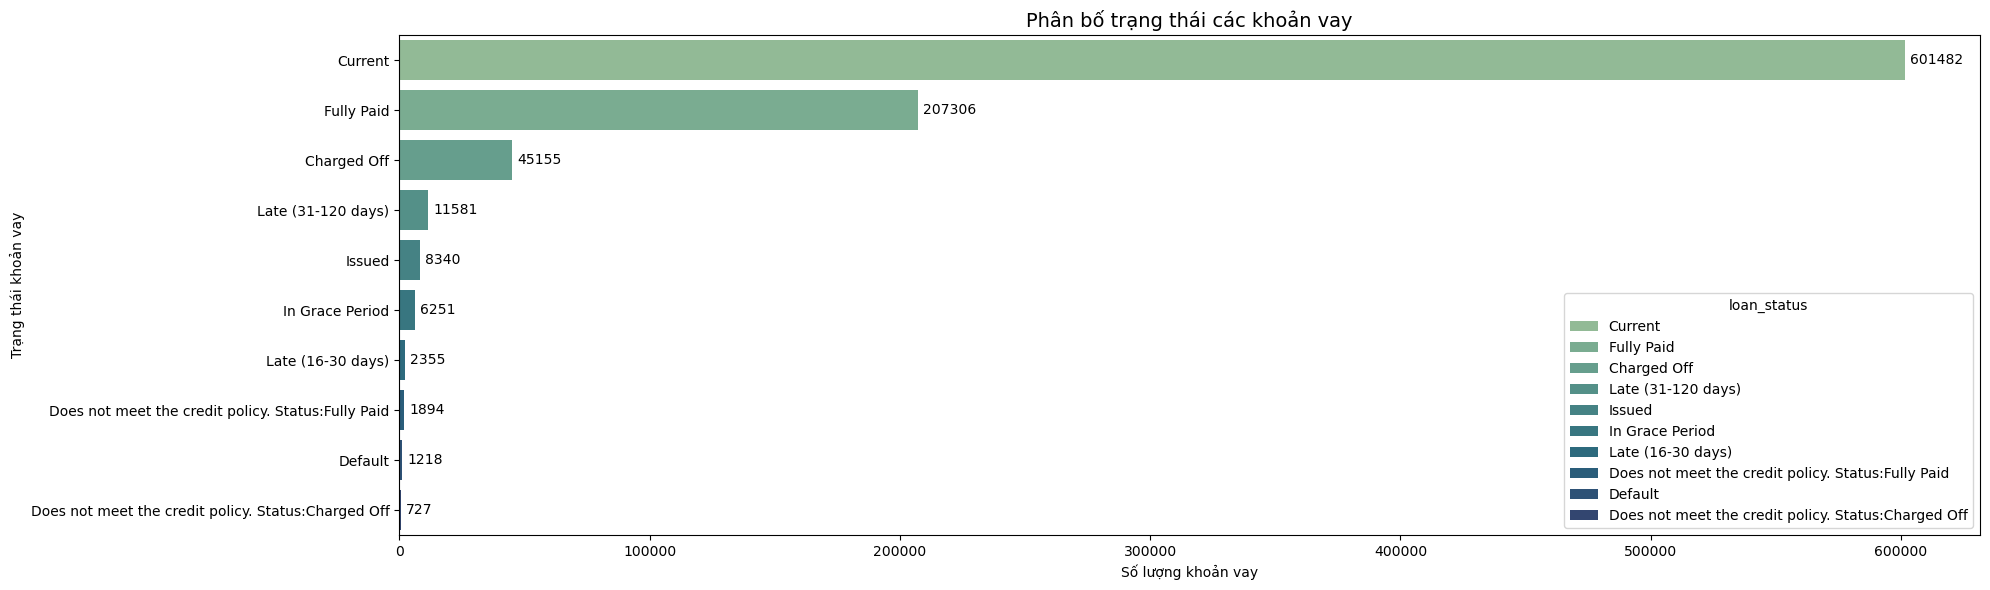

In [43]:
status_counts = (
    loan_status_history_df.groupBy("loan_status")
      .agg(count("*").alias("count"))
      .orderBy(col("count").desc())
)
status_counts.show()
status_counts_pd = status_counts.toPandas()

# Sắp xếp giảm dần theo số lượng
status_counts_pd = status_counts_pd.sort_values(by="count", ascending=False)

# Vẽ biểu đồ cột ngang
plt.figure(figsize=(20, 6))
sns.barplot(
    y="loan_status",
    x="count",
    hue="loan_status",       
    data=status_counts_pd,
    palette="crest",
    dodge=False,            
)

# Thêm nhãn số lượng bên phải từng cột
for index, row in status_counts_pd.iterrows():
    plt.text(
        row["count"] + 2000,
        index,
        str(row["count"]),
        va="center"
    )

# Tiêu đề và nhãn
plt.title("Phân bố trạng thái các khoản vay", fontsize=14)
plt.xlabel("Số lượng khoản vay")
plt.ylabel("Trạng thái khoản vay")
plt.tight_layout()
plt.show()

## Trung bình số dư gốc theo trạng thái

+--------------------+------------------+
|         loan_status|     avg_out_prncp|
+--------------------+------------------+
|              Issued|15289.389113908872|
|             Current|11761.248248925249|
|     In Grace Period| 11710.20442489202|
|  Late (31-120 days)|11691.441971332355|
|             Default|11601.024474548438|
|   Late (16-30 days)|11516.817779193208|
|          Fully Paid|               0.0|
|         Charged Off|               0.0|
|Does not meet the...|               0.0|
|Does not meet the...|               0.0|
+--------------------+------------------+



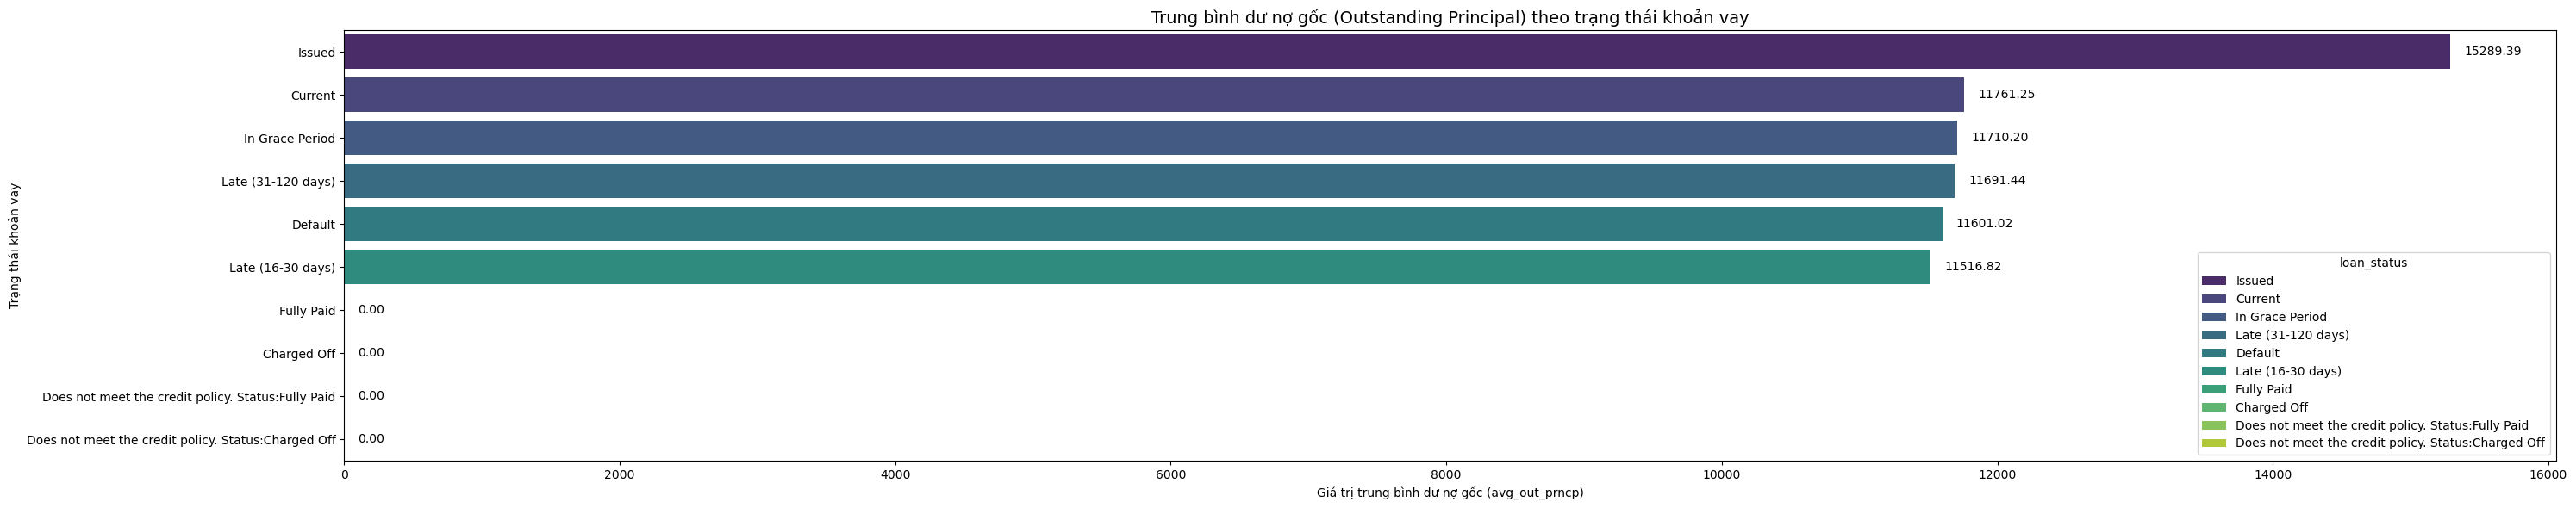

In [44]:
avg_out_prncp = (
    loan_status_history_df.groupBy("loan_status")
      .agg(avg("out_prncp").alias("avg_out_prncp"))
      .orderBy(col("avg_out_prncp").desc())
)
avg_out_prncp.show()
avg_out_prncp_pd = avg_out_prncp.toPandas()

avg_out_prncp_pd = avg_out_prncp_pd.sort_values(by="avg_out_prncp", ascending=False)

plt.figure(figsize=(30, 6))
sns.barplot(
    y="loan_status",
    x="avg_out_prncp",
    hue="loan_status",     
    data=avg_out_prncp_pd,
    palette="viridis",
    dodge=False
)

for index, row in avg_out_prncp_pd.iterrows():
    plt.text(
        row["avg_out_prncp"] + 100, 
        index,
        f"{row['avg_out_prncp']:.2f}",
        va="center"
    )

# Tiêu đề và nhãn
plt.title("Trung bình dư nợ gốc (Outstanding Principal) theo trạng thái khoản vay", fontsize=14)
plt.xlabel("Giá trị trung bình dư nợ gốc (avg_out_prncp)")
plt.ylabel("Trạng thái khoản vay")
plt.tight_layout()
plt.show()

##  Kế hoạch trả góp (pymnt_plan)


+----------+------+
|pymnt_plan| count|
+----------+------+
|         n|886299|
|         y|    10|
+----------+------+



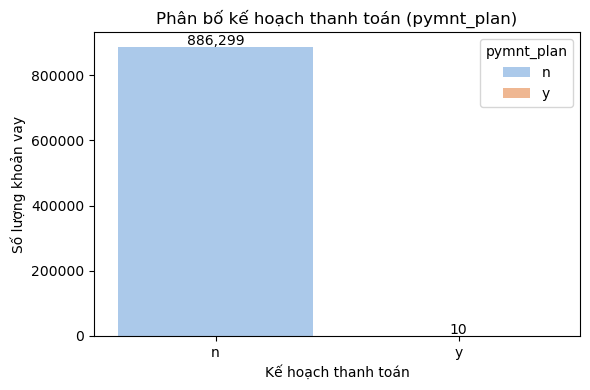

In [45]:
plan_counts = loan_status_history_df.groupBy("pymnt_plan").agg(count("*").alias("count"))
plan_counts.show()
plan_pd = plan_counts.toPandas()

# Vẽ biểu đồ
plt.figure(figsize=(6,4))
sns.barplot(
    x="pymnt_plan",
    y="count",
    hue="pymnt_plan",   # tránh FutureWarning
    data=plan_pd,
    palette="pastel",
    dodge=False,
)

# Thêm nhãn số trên mỗi thanh
for index, row in plan_pd.iterrows():
    plt.text(
        x=index,
        y=row["count"] + 5000,  # nâng nhãn lên trên thanh
        s=f"{row['count']:,}",
        ha="center"
    )

# Thêm tiêu đề và nhãn trục
plt.title("Phân bố kế hoạch thanh toán (pymnt_plan)")
plt.xlabel("Kế hoạch thanh toán")
plt.ylabel("Số lượng khoản vay")
plt.tight_layout()
plt.show()

## Trung bình gốc còn lại theo kế hoạch trả góp

+----------+-----------------------+
|pymnt_plan|avg_remaining_principal|
+----------+-----------------------+
|         n|      8407.364215970076|
|         y|              10535.823|
+----------+-----------------------+



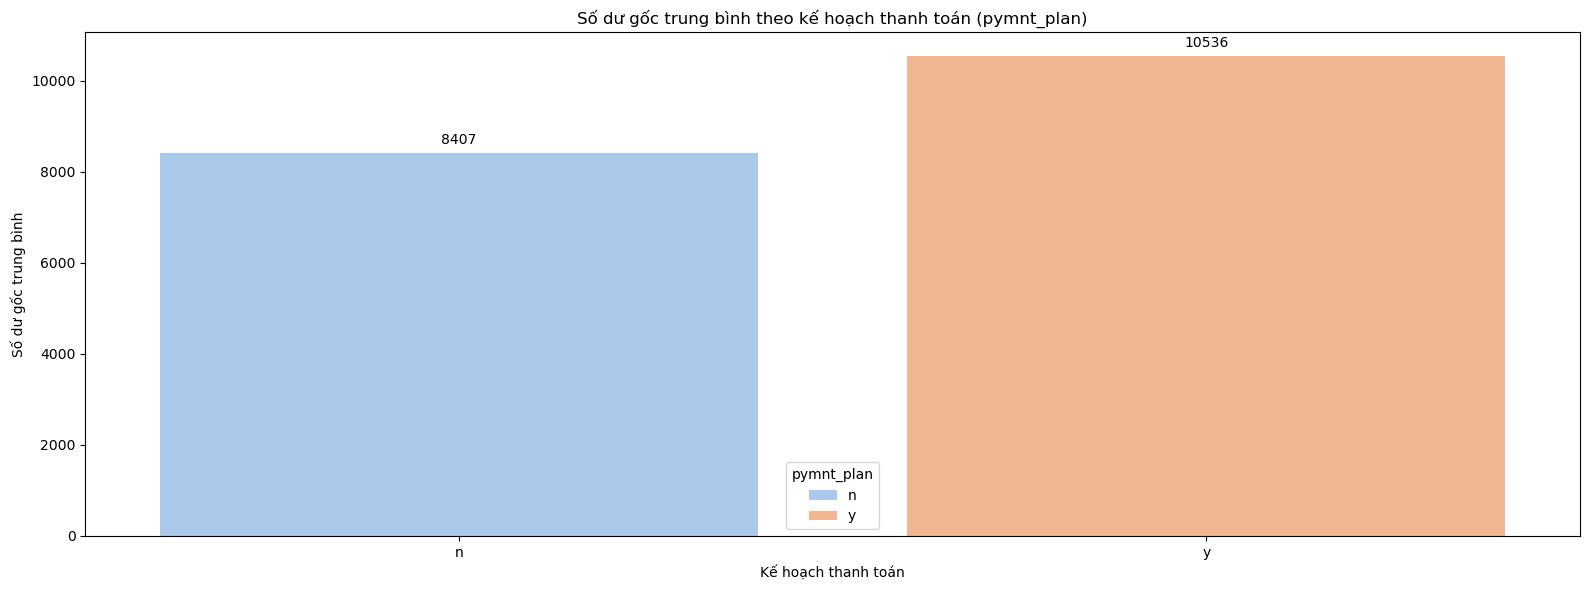

In [46]:
avg_principal_plan = (
    loan_status_history_df.groupBy("pymnt_plan")
      .agg(avg("out_prncp").alias("avg_remaining_principal"))
)
avg_principal_plan.show()
avg_principal_pd = avg_principal_plan.toPandas()

plt.figure(figsize=(16,6))
sns.barplot(
    x="pymnt_plan",
    y="avg_remaining_principal",
    hue="pymnt_plan",
    data=avg_principal_pd,
    palette="pastel",
    dodge=False
)

for index, row in avg_principal_pd.iterrows():
    plt.text(
        x=index,
        y=row["avg_remaining_principal"] + 200,
        s=f"{row['avg_remaining_principal']:.0f}",
        ha="center"
    )

plt.title("Số dư gốc trung bình theo kế hoạch thanh toán (pymnt_plan)")
plt.xlabel("Kế hoạch thanh toán")
plt.ylabel("Số dư gốc trung bình")
plt.tight_layout()
plt.show()

In [47]:
spark.stop()

# 4. Repayment_summary: Tổng hợp trả nợ vay

In [27]:
spark = SparkSession.builder \
    .master("spark://spark-master:7077") \
    .appName("RepaymentSummaryAnalysis") \
    .getOrCreate()

In [29]:
repayment_summary_df = (
    spark.read
    .option("header", True)
    .option("quote", '"')
    .option("delimiter", ",")
    .option("encoding", "UTF-8")
    .schema(repayment_summary_schema)
    .csv("hdfs://namenode:9000/bigdata/data/splitted_data/repayment_summary")
)
repayment_summary_df.printSchema()
repayment_summary_df.show(5)


root
 |-- id: integer (nullable = true)
 |-- total_pymnt: double (nullable = true)
 |-- total_pymnt_inv: double (nullable = true)
 |-- total_rec_prncp: double (nullable = true)
 |-- total_rec_int: double (nullable = true)
 |-- total_rec_late_fee: double (nullable = true)
 |-- recoveries: double (nullable = true)
 |-- collection_recovery_fee: double (nullable = true)

+--------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+
|      id|total_pymnt|total_pymnt_inv|total_rec_prncp|total_rec_int|total_rec_late_fee|recoveries|collection_recovery_fee|
+--------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+
|27531874|    10702.5|        10702.5|        10000.0|        702.5|               0.0|       0.0|                    0.0|
|27561712|   10536.45|       10536.45|        7811.23|      2725.22|               0.0|       0.0|                    0.0|
|27601687|   12

## Thống kê tổng quát

In [30]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, round, min as _min, max as _max, stddev
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
summary_stats = repayment_summary_df.select(
    round(avg("total_pymnt"), 2).alias("mean_total_pymnt"),
    round(stddev("total_pymnt"), 2).alias("std_total_pymnt"),
    _min("total_pymnt").alias("min_total_pymnt"),
    _max("total_pymnt").alias("max_total_pymnt"),
    round(avg("total_rec_prncp"), 2).alias("mean_principal"),
    round(avg("total_rec_int"), 2).alias("mean_interest"),
    round(avg("recoveries"), 2).alias("mean_recoveries"),
    round(avg("total_rec_late_fee"), 2).alias("mean_late_fee")
).toPandas()

print("\n=== Thống kê tổng quan ===")
print(summary_stats.T)


=== 📊 Thống kê tổng quan ===
                         0
mean_total_pymnt   7559.02
std_total_pymnt    7871.30
min_total_pymnt       0.00
max_total_pymnt   57777.58
mean_principal     5757.58
mean_interest      1755.17
mean_recoveries      45.88
mean_late_fee         0.39


In [32]:

numeric_cols = [
    "total_pymnt", "total_rec_prncp", "total_rec_int",
    "total_rec_late_fee", "recoveries", "collection_recovery_fee"
]
numeric_pd = repayment_summary_df.select(*numeric_cols).toPandas()

## Phân phối tổng tiền trả

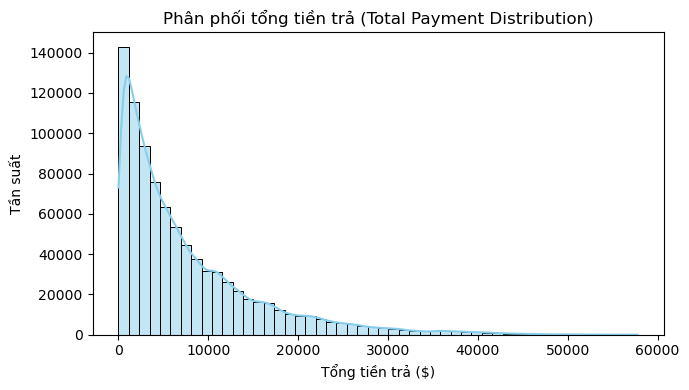

In [33]:

plt.figure(figsize=(7,4))
sns.histplot(numeric_pd["total_pymnt"], bins=50, kde=True, color="skyblue")
plt.title("Phân phối tổng tiền trả (Total Payment Distribution)")
plt.xlabel("Tổng tiền trả ($)")
plt.ylabel("Tần suất")
plt.tight_layout()
plt.show()

## Phân phối các chỉ số tài chính

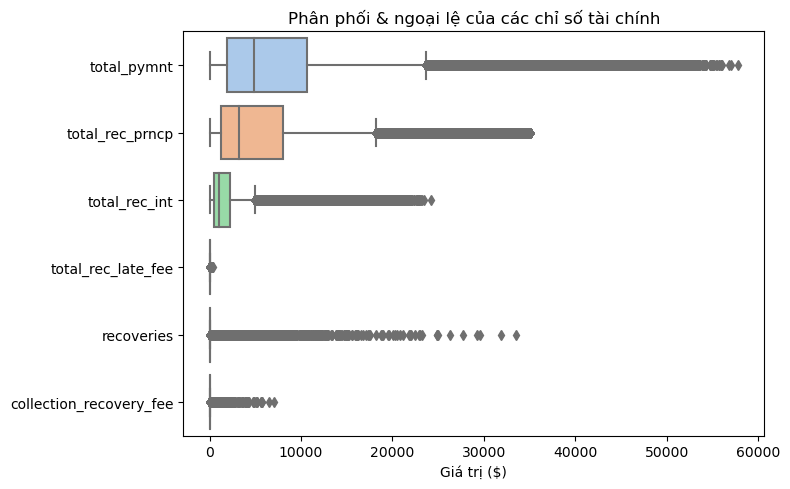

In [34]:

plt.figure(figsize=(8,5))
sns.boxplot(data=numeric_pd, orient="h", palette="pastel")
plt.title("Phân phối & ngoại lệ của các chỉ số tài chính")
plt.xlabel("Giá trị ($)")
plt.tight_layout()
plt.show()

## Trung bình gốc và lãi thu được

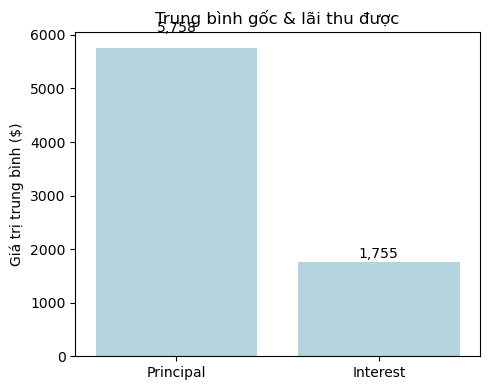

In [35]:

avg_principal_interest = repayment_summary_df.agg(
    round(avg("total_rec_prncp"), 2).alias("avg_principal"),
    round(avg("total_rec_int"), 2).alias("avg_interest")
).toPandas()

plt.figure(figsize=(5,4))
sns.barplot(
    x=["Principal", "Interest"], 
    y=[avg_principal_interest["avg_principal"][0], avg_principal_interest["avg_interest"][0]],
    color="lightblue"  
)
plt.title("Trung bình gốc & lãi thu được")
plt.ylabel("Giá trị trung bình ($)")
for i, v in enumerate([avg_principal_interest["avg_principal"][0], avg_principal_interest["avg_interest"][0]]):
    plt.text(i, v + 0.05*v, f"{v:,.0f}", ha='center')
plt.tight_layout()
plt.show()

## Hiệu quả hoàn trả

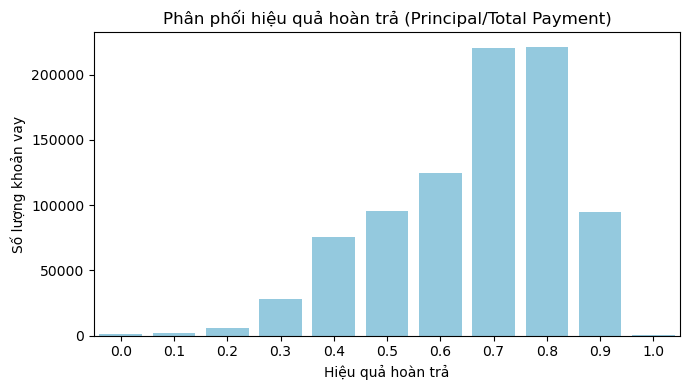

In [36]:

repayment_summary_df = repayment_summary_df.withColumn(
    "repayment_efficiency",
    round(col("total_rec_prncp") / col("total_pymnt"), 3)
)

efficiency_bins = (
    repayment_summary_df
    .withColumn("efficiency_range",
        (col("repayment_efficiency")*10).cast("int")/10
    )
    .groupBy("efficiency_range")
    .count()
    .orderBy("efficiency_range")
)

efficiency_pd = efficiency_bins.toPandas()

plt.figure(figsize=(7,4))
sns.barplot(
    x="efficiency_range",
    y="count",
    data=efficiency_pd,
    color="skyblue"
)
plt.title("Phân phối hiệu quả hoàn trả (Principal/Total Payment)")
plt.xlabel("Hiệu quả hoàn trả")
plt.ylabel("Số lượng khoản vay")
plt.tight_layout()
plt.show()

## Tương quan recoveries và collection recovery fee

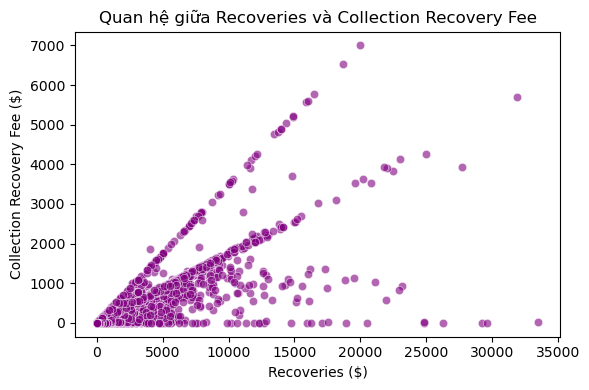

In [37]:

recoveries_pd = repayment_summary_df.select(
    "recoveries", "collection_recovery_fee"
).toPandas()

plt.figure(figsize=(6,4))
sns.scatterplot(
    data=recoveries_pd,
    x="recoveries",
    y="collection_recovery_fee",
    alpha=0.6,
    color="purple"
)
plt.title("Quan hệ giữa Recoveries và Collection Recovery Fee")
plt.xlabel("Recoveries ($)")
plt.ylabel("Collection Recovery Fee ($)")
plt.tight_layout()
plt.show()

## Ma trận tương quan

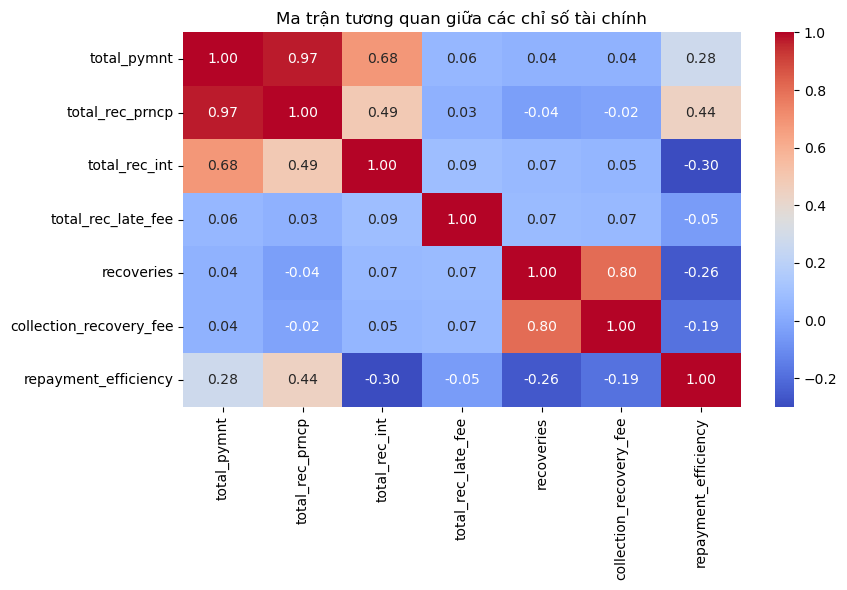

In [39]:

corr_pd = repayment_summary_df.select(
    "total_pymnt", "total_rec_prncp", "total_rec_int",
    "total_rec_late_fee", "recoveries", "collection_recovery_fee",
    "repayment_efficiency"
).toPandas()

plt.figure(figsize=(9,6))
sns.heatmap(corr_pd.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Ma trận tương quan giữa các chỉ số tài chính")
plt.tight_layout()
plt.show()

In [40]:
spark.stop()

# 5. Credit profile

In [16]:
from pyspark.sql import functions as F
from pyspark.sql.functions import col, datediff, current_date, to_date, regexp_replace

In [17]:
spark = SparkSession.builder \
    .master("spark://spark-master:7077") \
    .appName("CreditProfileAnalysis") \
    .getOrCreate()


In [18]:
credit_profile_df = (
    spark.read
    .option("header", True)
    .option("quote", '"')
    .option("delimiter", ",")
    .option("encoding", "UTF-8")
    .schema(credit_profile_schema)
    .csv("hdfs://namenode:9000/bigdata/data/splitted_data/credit_profile")
)
credit_profile_df.printSchema()
credit_profile_df.show(5)

root
 |-- id: integer (nullable = true)
 |-- member_id: integer (nullable = true)
 |-- delinq_2yrs: double (nullable = true)
 |-- earliest_cr_line: string (nullable = true)
 |-- inq_last_6mths: double (nullable = true)
 |-- mths_since_last_delinq: double (nullable = true)
 |-- mths_since_last_record: double (nullable = true)
 |-- open_acc: double (nullable = true)
 |-- pub_rec: double (nullable = true)
 |-- revol_bal: double (nullable = true)
 |-- revol_util: double (nullable = true)
 |-- total_acc: double (nullable = true)
 |-- collections_12_mths_ex_med: double (nullable = true)
 |-- mths_since_last_major_derog: double (nullable = true)

+--------+---------+-----------+----------------+--------------+----------------------+----------------------+--------+-------+---------+----------+---------+--------------------------+---------------------------+
|      id|member_id|delinq_2yrs|earliest_cr_line|inq_last_6mths|mths_since_last_delinq|mths_since_last_record|open_acc|pub_rec|revol_bal|r

In [19]:
credit_profile_pdf = credit_profile_df.toPandas()

## Tương quan các biến

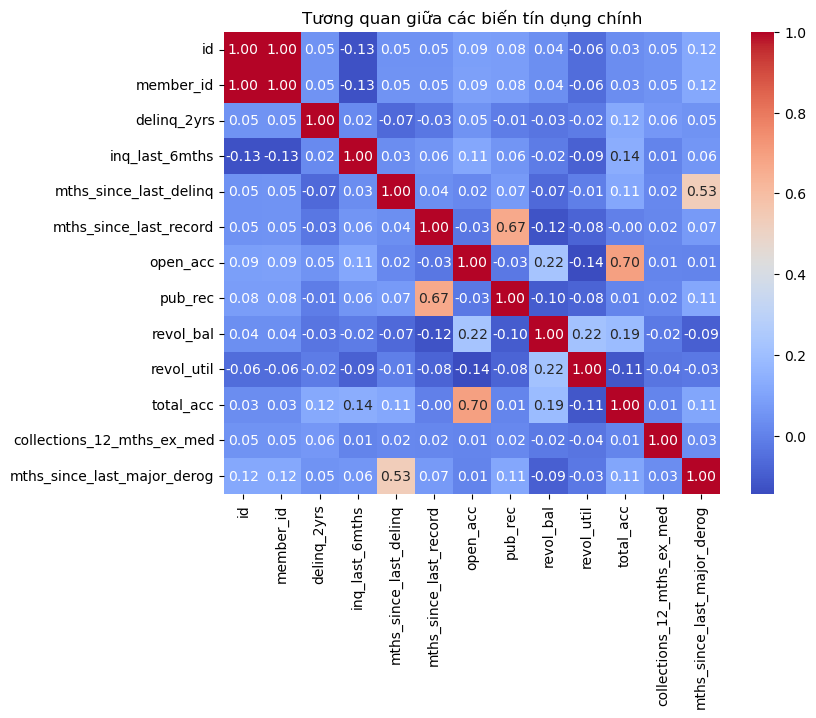

In [20]:
numeric_cols = [c for c, t in credit_profile_df.dtypes if t in ('int', 'double')]
credit_profile_pdf_corr = credit_profile_df.select(numeric_cols).toPandas().corr()

credit_profile_df_corr = spark.createDataFrame(
    credit_profile_pdf_corr.reset_index().melt(id_vars='index', var_name='variable', value_name='correlation')
).withColumnRenamed('index','feature')


plt.figure(figsize=(8,6))
sns.heatmap(credit_profile_pdf_corr, cmap='coolwarm', annot=True, fmt='.2f')
plt.title("Tương quan giữa các biến tín dụng chính")
plt.show()

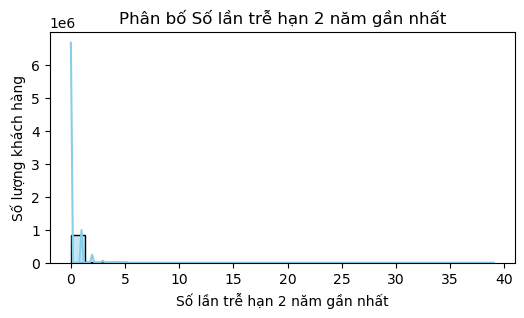

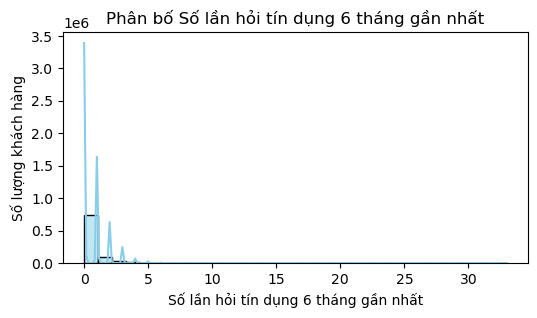

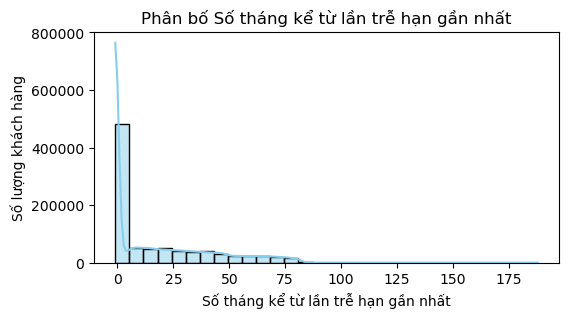

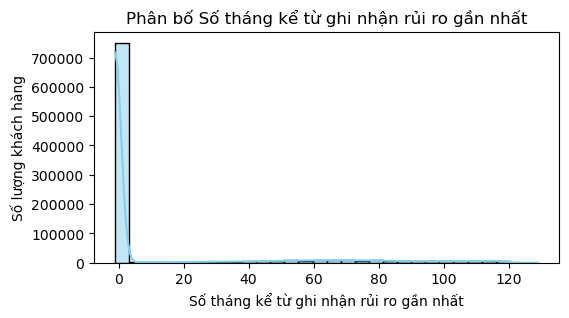

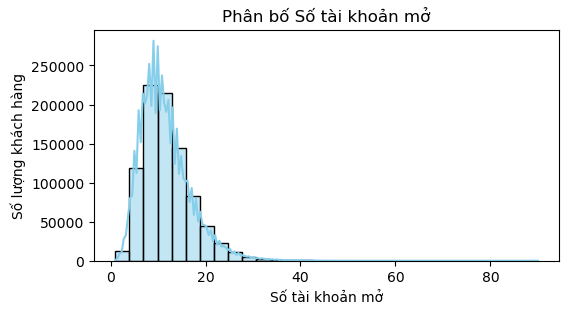

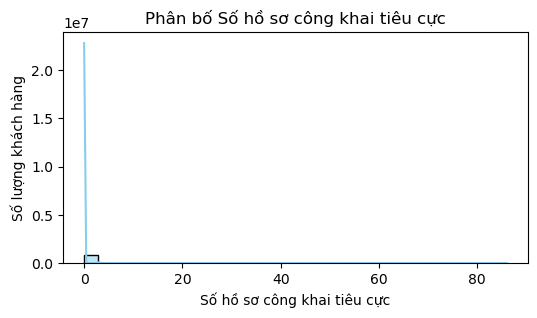

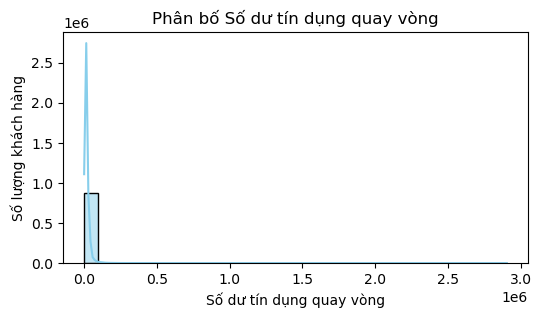

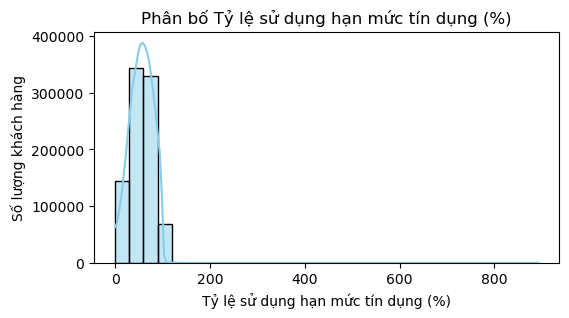

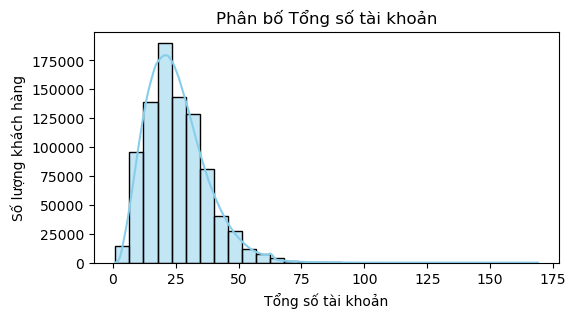

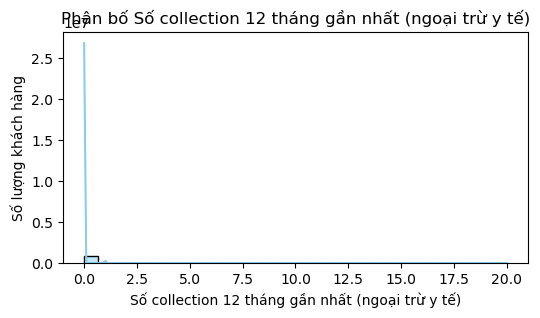

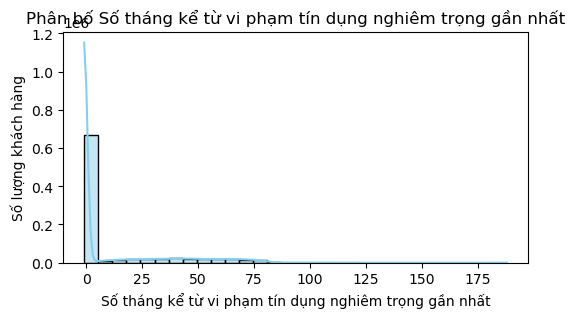

In [21]:

col_vn = {
    "delinq_2yrs": "Số lần trễ hạn 2 năm gần nhất",
    "inq_last_6mths": "Số lần hỏi tín dụng 6 tháng gần nhất",
    "mths_since_last_delinq": "Số tháng kể từ lần trễ hạn gần nhất",
    "mths_since_last_record": "Số tháng kể từ ghi nhận rủi ro gần nhất",
    "open_acc": "Số tài khoản mở",
    "pub_rec": "Số hồ sơ công khai tiêu cực",
    "revol_bal": "Số dư tín dụng quay vòng",
    "revol_util": "Tỷ lệ sử dụng hạn mức tín dụng (%)",
    "total_acc": "Tổng số tài khoản",
    "collections_12_mths_ex_med": "Số collection 12 tháng gần nhất (ngoại trừ y tế)",
    "mths_since_last_major_derog": "Số tháng kể từ vi phạm tín dụng nghiêm trọng gần nhất"
}

numeric_cols = list(col_vn.keys())

for col_name in numeric_cols:
    plt.figure(figsize=(6,3))
    sns.histplot(credit_profile_pdf[col_name].dropna(), bins=30, kde=True, color="skyblue")
    plt.title(f"Phân bố {col_vn[col_name]}")
    plt.xlabel(col_vn[col_name])
    plt.ylabel("Số lượng khách hàng")
    plt.show()

## Phân phối nhóm tài khoản sử dụng

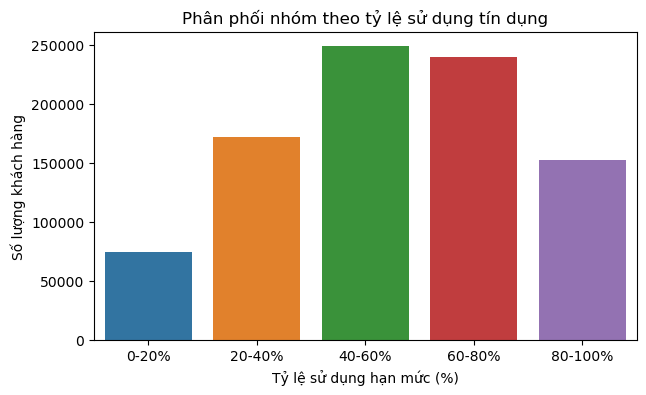

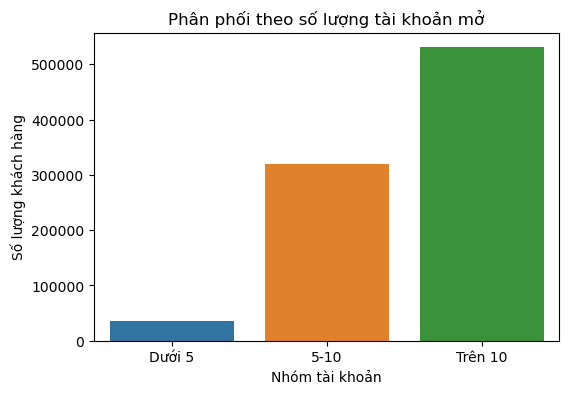

In [22]:

credit_profile_df_distribution = credit_profile_df.withColumn(
    "Nhóm_tỷ_lệ_sử_dụng", 
    when(col("revol_util") < 20, "0-20%")
    .when(col("revol_util") < 40, "20-40%")
    .when(col("revol_util") < 60, "40-60%")
    .when(col("revol_util") < 80, "60-80%")
    .otherwise("80-100%")
).withColumn(
    "Nhóm_số_tài_khoản",   
    when(col("open_acc") < 5, "Dưới 5")
    .when(col("open_acc") < 10, "5-10")
    .otherwise("Trên 10")
)

credit_profile_pdf_dist = credit_profile_df_distribution.toPandas()

plt.figure(figsize=(7,4))
sns.countplot(x="Nhóm_tỷ_lệ_sử_dụng", data=credit_profile_pdf_dist,
              order=["0-20%","20-40%","40-60%","60-80%","80-100%"])
plt.title("Phân phối nhóm theo tỷ lệ sử dụng tín dụng")
plt.xlabel("Tỷ lệ sử dụng hạn mức (%)")
plt.ylabel("Số lượng khách hàng")
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(x="Nhóm_số_tài_khoản", data=credit_profile_pdf_dist,
              order=["Dưới 5","5-10","Trên 10"])
plt.title("Phân phối theo số lượng tài khoản mở")
plt.xlabel("Nhóm tài khoản")
plt.ylabel("Số lượng khách hàng")
plt.show()


## Tỉ lệ rủi ro theo nhóm tỷ lệ sử dụng tín dụng

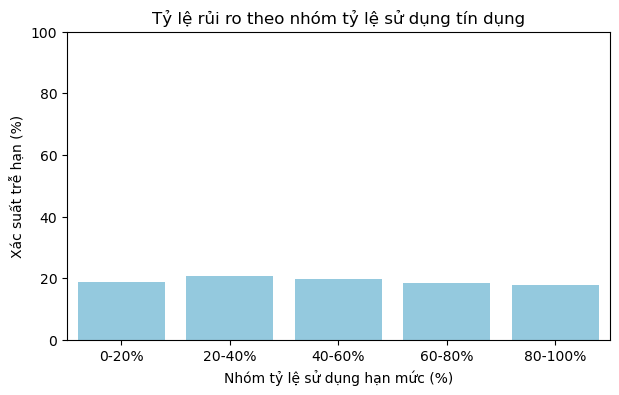

In [23]:
credit_profile_df_behavior_risk = credit_profile_df.withColumn(
    "Cờ_rủi_ro",
    when(col("delinq_2yrs") > 0, 1).otherwise(0)
).withColumn(
    "Nhóm_tỷ_lệ_sử_dụng",
    when(col("revol_util") < 20, "0-20%")
    .when(col("revol_util") < 40, "20-40%")
    .when(col("revol_util") < 60, "40-60%")
    .when(col("revol_util") < 80, "60-80%")
    .otherwise("80-100%")
)

credit_profile_pdf_risk = credit_profile_df_behavior_risk.groupBy("Nhóm_tỷ_lệ_sử_dụng") \
    .agg((mean("Cờ_rủi_ro") * 100).alias("Tỷ_lệ_rủi_ro_%")) \
    .orderBy("Nhóm_tỷ_lệ_sử_dụng") \
    .toPandas()

plt.figure(figsize=(7,4))
sns.barplot(
    x="Nhóm_tỷ_lệ_sử_dụng",
    y="Tỷ_lệ_rủi_ro_%",
    data=credit_profile_pdf_risk,
    order=["0-20%","20-40%","40-60%","60-80%","80-100%"],
    color="skyblue"
)
plt.title("Tỷ lệ rủi ro theo nhóm tỷ lệ sử dụng tín dụng")
plt.xlabel("Nhóm tỷ lệ sử dụng hạn mức (%)")
plt.ylabel("Xác suất trễ hạn (%)")
plt.ylim(0, 100)
plt.show()

## Phân khúc khách hàng theo mức độ rủi ro tín dụng

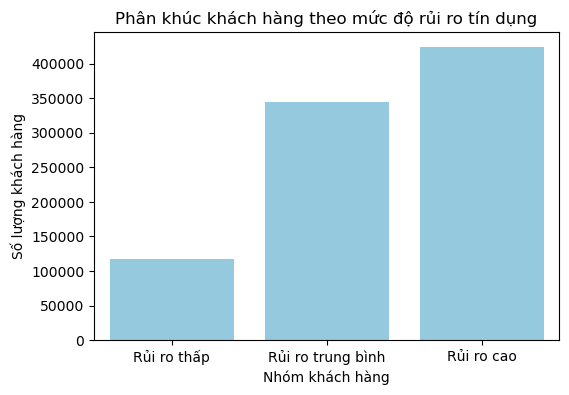

In [25]:

credit_profile_df_segments = credit_profile_df.withColumn(
    "Phân_khúc", 
    when((col("revol_util") < 30) & (col("delinq_2yrs")==0), "Rủi ro thấp")
    .when((col("revol_util") < 60) & (col("delinq_2yrs") <= 1), "Rủi ro trung bình")
    .otherwise("Rủi ro cao")
)

credit_profile_pdf_seg = credit_profile_df_segments.toPandas()

plt.figure(figsize=(6,4))
sns.countplot(x="Phân_khúc", data=credit_profile_pdf_seg,
              order=["Rủi ro thấp", "Rủi ro trung bình", "Rủi ro cao"],
              color="skyblue")
plt.title("Phân khúc khách hàng theo mức độ rủi ro tín dụng")
plt.xlabel("Nhóm khách hàng")
plt.ylabel("Số lượng khách hàng")
plt.show()

In [26]:
spark.stop()

# 6.Credit account detail

In [4]:
spark = SparkSession.builder \
    .master("spark://spark-master:7077") \
    .appName("CreditAccountAnalysis") \
    .getOrCreate()

In [5]:
credit_account_detail_df = (
    spark.read
    .option("header", True)
    .option("quote", '"')
    .option("delimiter", ",")
    .option("encoding", "UTF-8")
    .schema(credit_account_detail_schema)
    .csv("hdfs://namenode:9000/bigdata/data/splitted_data/credit_account_detail")
)
credit_account_detail_df.printSchema()
credit_account_detail_df.show(5)

root
 |-- id: integer (nullable = true)
 |-- member_id: integer (nullable = true)
 |-- open_acc_6m: double (nullable = true)
 |-- open_il_6m: double (nullable = true)
 |-- open_il_12m: double (nullable = true)
 |-- open_il_24m: double (nullable = true)
 |-- mths_since_rcnt_il: double (nullable = true)
 |-- total_bal_il: double (nullable = true)
 |-- il_util: double (nullable = true)
 |-- open_rv_12m: double (nullable = true)
 |-- open_rv_24m: double (nullable = true)
 |-- max_bal_bc: double (nullable = true)
 |-- all_util: double (nullable = true)
 |-- total_rev_hi_lim: double (nullable = true)
 |-- tot_coll_amt: double (nullable = true)
 |-- tot_cur_bal: double (nullable = true)
 |-- inq_fi: double (nullable = true)
 |-- total_cu_tl: double (nullable = true)
 |-- inq_last_12m: double (nullable = true)

+--------+---------+-----------+----------+-----------+-----------+------------------+------------+-------+-----------+-----------+----------+--------+----------------+------------+----

In [6]:
col_vn = {
    "open_acc_6m": "Số tài khoản mở trong 6 tháng",
    "open_il_6m": "Số khoản vay trả góp mở 6 tháng",
    "open_il_12m": "Số khoản vay trả góp mở 12 tháng",
    "open_il_24m": "Số khoản vay trả góp mở 24 tháng",
    "mths_since_rcnt_il": "Số tháng từ khoản vay trả góp gần nhất",
    "total_bal_il": "Tổng dư nợ vay trả góp",
    "il_util": "Tỷ lệ sử dụng tín dụng vay trả góp (%)",
    "open_rv_12m": "Số tài khoản quay vòng mở 12 tháng",
    "open_rv_24m": "Số tài khoản quay vòng mở 24 tháng",
    "max_bal_bc": "Số dư cao nhất của thẻ tín dụng",
    "all_util": "Tỷ lệ sử dụng tổng tín dụng (%)",
    "total_rev_hi_lim": "Tổng hạn mức tín dụng cao nhất",
    "tot_coll_amt": "Tổng số tiền bị thu hồi",
    "tot_cur_bal": "Tổng dư nợ hiện tại",
    "inq_fi": "Số lần hỏi tín dụng tài chính gần đây",
    "total_cu_tl": "Tổng số tài khoản tín dụng hợp nhất",
    "inq_last_12m": "Số lần hỏi tín dụng 12 tháng gần nhất"
}

credit_account_detail_pdf = credit_account_detail_df.select(*col_vn.keys()).toPandas()

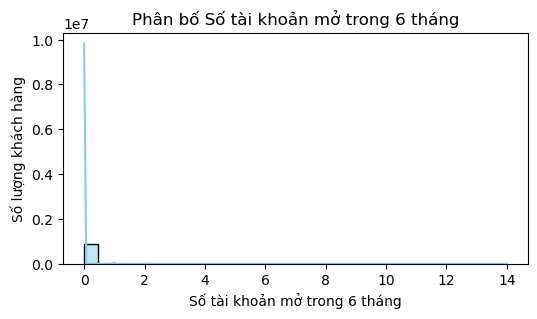

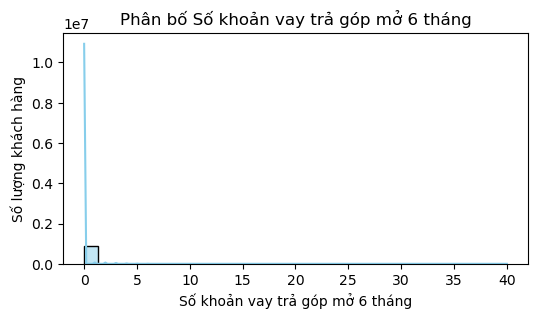

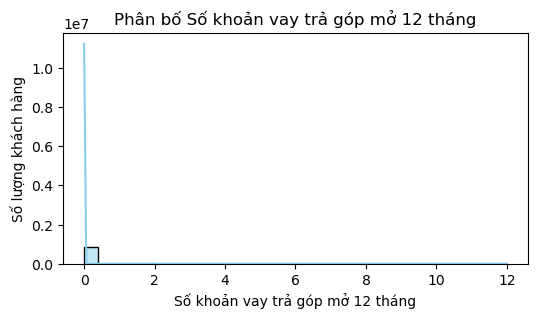

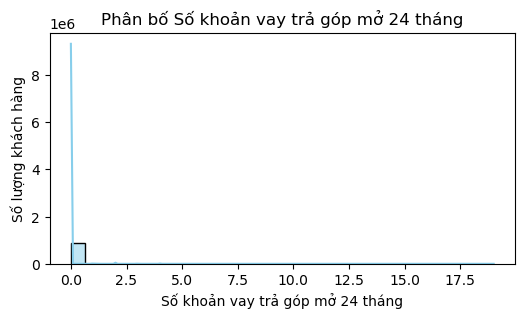

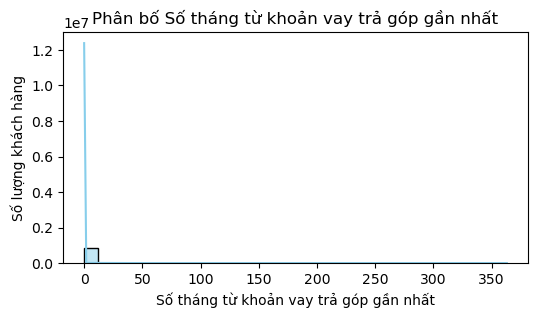

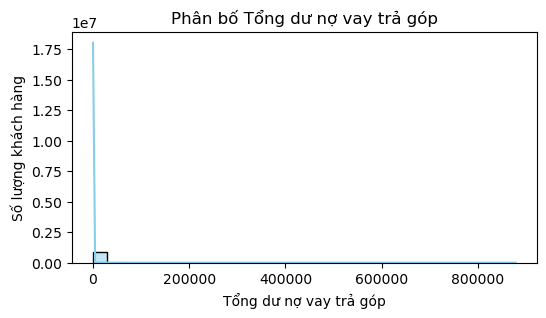

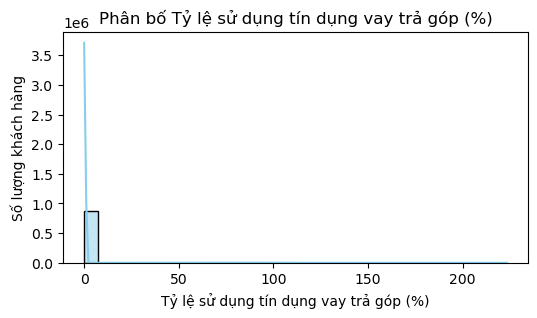

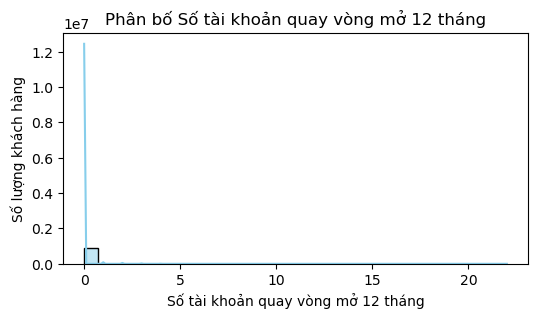

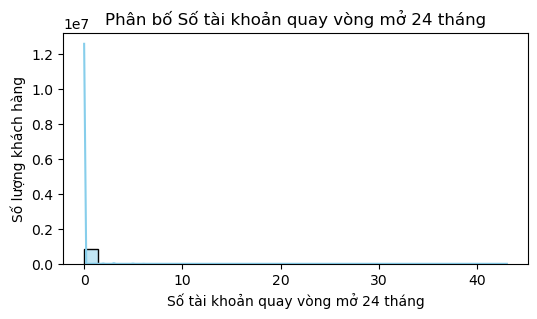

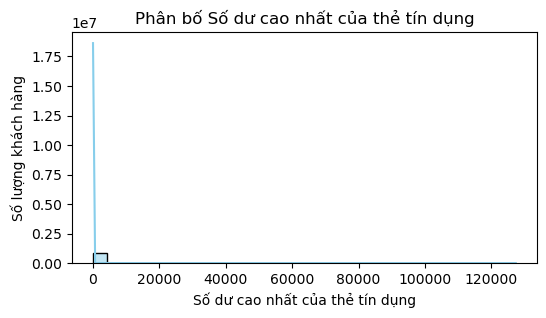

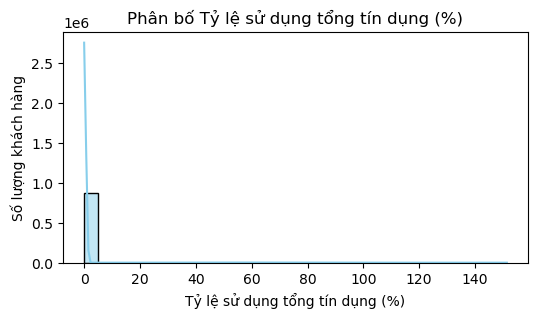

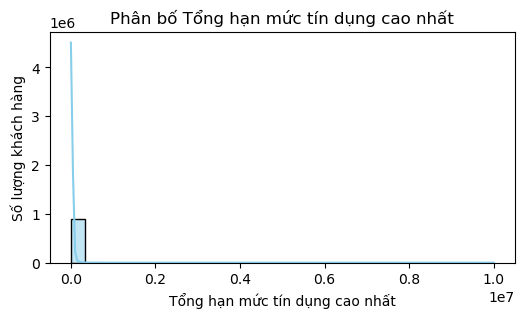

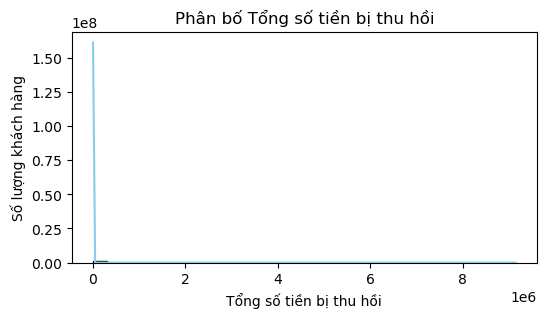

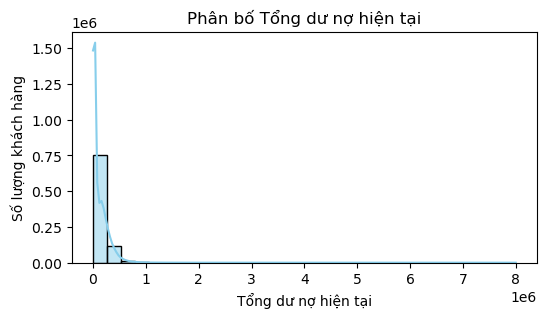

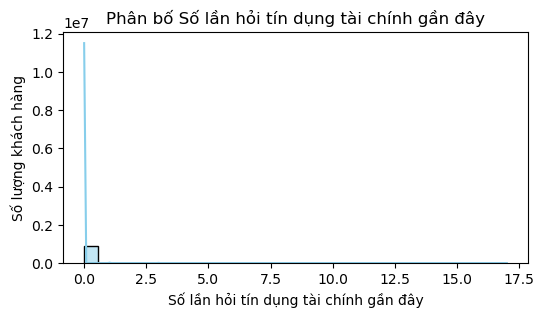

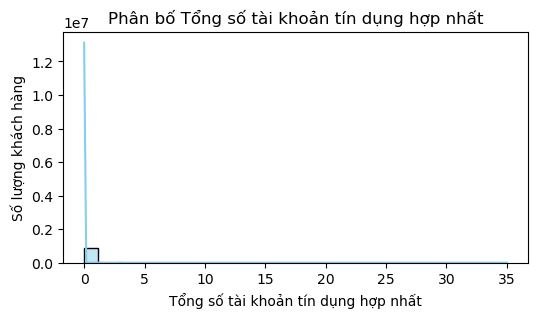

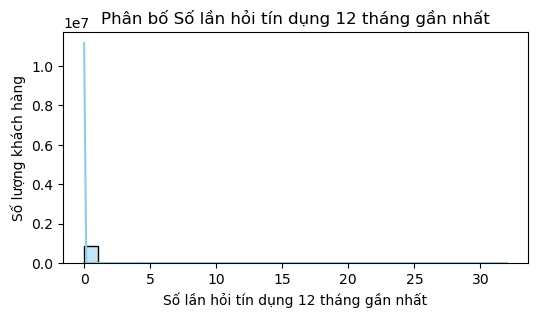

In [7]:
for col_name, col_label in col_vn.items():
    plt.figure(figsize=(6,3))
    sns.histplot(credit_account_detail_pdf[col_name].dropna(), bins=30, kde=True, color="skyblue")
    plt.title(f"Phân bố {col_label}")
    plt.xlabel(col_label)
    plt.ylabel("Số lượng khách hàng")
    plt.show()

## Ma trận tương quan

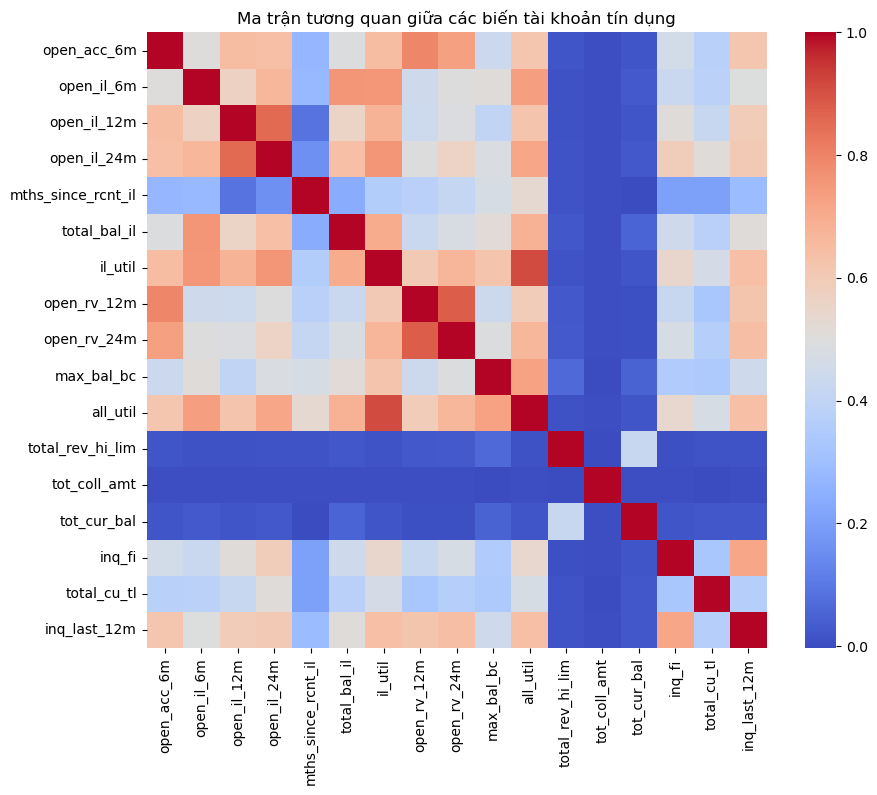

In [9]:
credit_account_detail_pdf_corr = credit_account_detail_pdf.corr()
plt.figure(figsize=(10,8))
sns.heatmap(credit_account_detail_pdf_corr, cmap="coolwarm", annot=False)
plt.title("Ma trận tương quan giữa các biến tài khoản tín dụng")
plt.show()

## Tỉ lệ nợ trên hạn mức ( (total_bal_il + max_bal_bc)/total_rev_hi_lim )

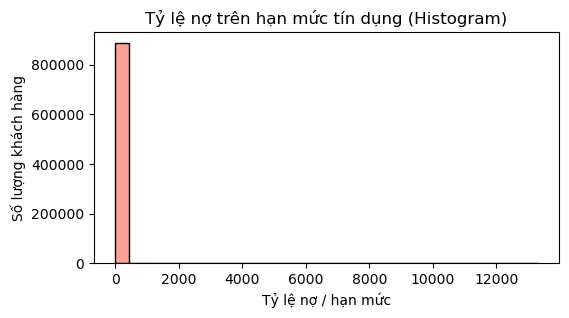

In [11]:
credit_account_detail_df_debt_ratio = credit_account_detail_df.withColumn(
    "Tỷ_lệ_nợ_trên_hạn_mức",
    (col("total_bal_il") + col("max_bal_bc")) / (col("total_rev_hi_lim") + 1)
)
credit_account_detail_pdf_debt = credit_account_detail_df_debt_ratio.select("Tỷ_lệ_nợ_trên_hạn_mức").toPandas()

# Histogram
plt.figure(figsize=(6,3))
sns.histplot(credit_account_detail_pdf_debt["Tỷ_lệ_nợ_trên_hạn_mức"].dropna(), bins=30, kde=False, color="salmon")
plt.title("Tỷ lệ nợ trên hạn mức tín dụng (Histogram)")
plt.xlabel("Tỷ lệ nợ / hạn mức")
plt.ylabel("Số lượng khách hàng")
plt.show()

## Hoạt động tín dụng gần

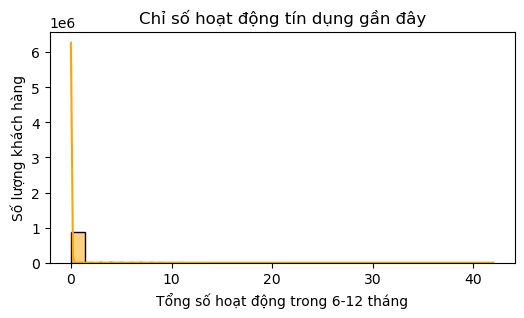

In [12]:
credit_account_detail_df_recent_activity = credit_account_detail_df.withColumn(
    "Hoạt_động_tín_dụng_gần",
    col("open_acc_6m") + col("open_il_6m") + col("inq_last_12m")
)

credit_account_detail_pdf_recent = credit_account_detail_df_recent_activity.select("Hoạt_động_tín_dụng_gần").toPandas()

plt.figure(figsize=(6,3))
sns.histplot(credit_account_detail_pdf_recent["Hoạt_động_tín_dụng_gần"], bins=30, kde=True, color="orange")
plt.title("Chỉ số hoạt động tín dụng gần đây")
plt.xlabel("Tổng số hoạt động trong 6-12 tháng")
plt.ylabel("Số lượng khách hàng")
plt.show()

## Tỉ lệ nợ trên hạn mức ( (total_bal_il + max_bal_bc) /total_rev_hi_lim )

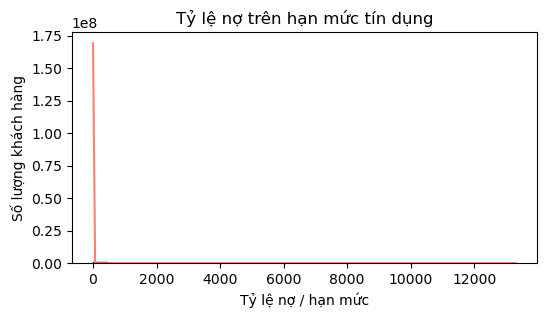

In [13]:
credit_account_detail_df_debt_ratio = credit_account_detail_df.withColumn(
    "Tỷ_lệ_nợ_trên_hạn_mức",
    (col("total_bal_il") + col("max_bal_bc")) / (col("total_rev_hi_lim") + 1)
)

credit_account_detail_pdf_debt = credit_account_detail_df_debt_ratio.select("Tỷ_lệ_nợ_trên_hạn_mức").toPandas()

plt.figure(figsize=(6,3))
sns.histplot(credit_account_detail_pdf_debt["Tỷ_lệ_nợ_trên_hạn_mức"].dropna(), bins=30, kde=True, color="salmon")
plt.title("Tỷ lệ nợ trên hạn mức tín dụng")
plt.xlabel("Tỷ lệ nợ / hạn mức")
plt.ylabel("Số lượng khách hàng")
plt.show()

## Nhóm sử dụng tín dụng


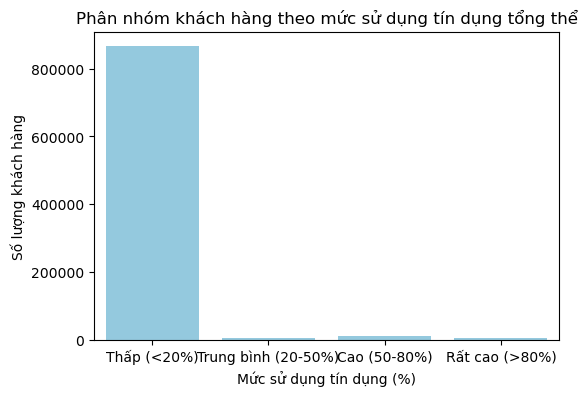

In [14]:
credit_account_detail_df_util_band = credit_account_detail_df.withColumn(
    "Nhóm_sử_dụng_tín_dụng",
    when(col("all_util") < 20, "Thấp (<20%)")
    .when(col("all_util") < 50, "Trung bình (20-50%)")
    .when(col("all_util") < 80, "Cao (50-80%)")
    .otherwise("Rất cao (>80%)")
)

credit_account_detail_pdf_util = credit_account_detail_df_util_band.groupBy("Nhóm_sử_dụng_tín_dụng").count().toPandas()

plt.figure(figsize=(6,4))
sns.barplot(x="Nhóm_sử_dụng_tín_dụng", y="count", data=credit_account_detail_pdf_util,
            order=["Thấp (<20%)","Trung bình (20-50%)","Cao (50-80%)","Rất cao (>80%)"],
            color="skyblue")
plt.title("Phân nhóm khách hàng theo mức sử dụng tín dụng tổng thể")
plt.xlabel("Mức sử dụng tín dụng (%)")
plt.ylabel("Số lượng khách hàng")
plt.show()

In [15]:
spark.stop()